In [71]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_style('whitegrid')

# sns.set_context('notebook')

# %matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
%load_ext autoreload
%autoreload 2

dev = 'cuda'
root = '/home/ubuntu/ext_vol'
import sys
sys.path.insert(0, f'{root}/inpca')

from utils import get_data, get_idx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import plotly.graph_objects as go
import numpy as np
import plotly.offline as pyo
import pandas as pd
pyo.init_notebook_mode()

## Plotly

In [73]:
def plotly_3d(dc, r, emph=[], empcolor='darkred', empsize=10, empmode='markers',
              return_text=False, return_d=False, ne=3, dims=[1, 2, 3],
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              groups = ['seed', 'm', 'opt', 'bs', 'aug', 'bn', 'lr', 'wd', 'corner'],
              color='t', cmap=None, colorscale='RdBu', mode='markers', separate_traj=False, axis_range=[-1, 1]):

    for (config, idxs) in dc.groupby(['m', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
        tmax = dc.iloc[idxs]['t'].max()
        dc.loc[idxs, 't'] /= tmax
    for i in range(ne):
        dc[f"x{i+1}"] = r['xp'][:, i]
    d_ = dc
        
    for col in cols:
        dc[col] = f'{col}: ' + dc[col].astype(str)
    text = dc[cols].apply("<br>".join, axis=1)
    text = 't: ' + dc['t'].astype(str) + '<br>' + text
    
    c = dc[color]
    if cmap is not None:
        c = c.map(cmap)

    size = 2 * np.ones(len(dc))

    if separate_traj:
        fig = go.Figure()
        for (i, (conds, ii)) in enumerate(list(d_.groupby(groups).indices.items())):
            dc_ = dc.iloc[ii].reset_index()
            fig.add_trace(
                go.Scatter3d(
                x=dc_[f'x{dims[0]}'],  
                y=dc_[f'x{dims[1]}'],  
                z=dc_[f'x{dims[2]}'],  
                hovertemplate='<b>%{text}</b><extra></extra>',
                text=text[ii],
                marker=dict(
                    size=2,
                    opacity=0.8,
                    color=c[ii],
                    symbolsrc='m',
                    colorscale='s',
                ),
                mode=mode,
                line=dict(
                    color=c[ii],
                    width=2,
                ),
                name=conds[-1]
            ),
                
            )
    else:
        
        fig = go.Figure(data=[
            go.Scatter3d(
                x=dc[f'x{dims[0]}'],  
                y=dc[f'x{dims[1]}'],  
                z=dc[f'x{dims[2]}'],  
                hovertemplate='<b>%{text}</b><extra></extra>',
                text=text,
                marker=dict(
                    size=2,
                    opacity=0.8,
                    color=c,
                    symbolsrc='m',
                    colorscale=colorscale,
                ),
                mode='markers',
            )
        ])
        if len(emph) > 0:
            for ie in emph:
                demph = dc.iloc[ie]
                fig.add_trace(
                go.Scatter3d(
                    x=demph[f'x{dims[0]}'],  
                    y=demph[f'x{dims[1]}'],  
                    z=demph[f'x{dims[2]}'],  

                    marker=dict(
                        size=empsize,
                        opacity=0.8,
                        color=empcolor,
                    ),
                    mode=empmode,
                    )
                )
    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000,
        scene_xaxis_range=axis_range,
    scene_yaxis_range=axis_range,
    scene_zaxis_range=axis_range,
    scene_aspectmode='cube')

    print(r['e'])

    results = [fig]
    if return_text: 
        results.append(text)
    if return_d:
        results.append(d_)
    return results

def plotly_2d(dc, text, ne=3):
    fig = go.Figure(data=go.Splom(
                dimensions=[dict(label=f'x{i}',
                                 values=dc[f'x{i}']) for i in range(1, ne+1)],
                showupperhalf=False, # remove plots on diagonal
                diagonal_visible=False,
                text=text,
                marker=dict(color=dc.t,
                            showscale=False, # colors encode categorical variables
                            line_color='white', size=2, opacity=0.8)
                ), )


    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000
    )

    fig.show()

In [74]:
def triplot(dc, r, d=3, emph=[], cmap='vlag', cdict=None, ckey='', skey='', sdict={},
            markers=["o", "x", "s", "*", "+"],
            evals=False, plot_avg=False, avggroupby=['opt'], plot_lines=False,
            xrange=[-1, 1], yrange=[-1, 1]
            ):
    figs, axs = plt.subplots(d-1, d-1, figsize=(12, 12),
                            sharex=True, sharey=True)
    ee = r['e']
    c = dc[ckey]
    if skey:
        s = dc[skey]
    else:
        s = 2
        
    if cdict:
        c = c.fillna('nan')
        c = c.map(cdict)
        print(cdict)  
   

    for (i1, d1) in enumerate(range(d-1)):
        for (i2, d2) in enumerate(range(d1+1, d)):
            if d2 > d1 + 1:
                axs[d1, d2-1].set_visible(False)
            ax = axs[d2-1, d1]
            ax.axis("square")

            xx = r['xp']
            sc = ax.scatter(xx[:, d1], xx[:, d2],
                            c=c, cmap=cmap, vmin=c.min(), vmax=c.max(), s=s, lw=0.5, alpha=0.5)
            if len(emph) > 0:
                sc_emph = ax.scatter(xx[emph, d1], xx[emph, d2],
                            c='red', s=s+10, lw=0.5, alpha=0.5)
            ax.set_xlim(xrange)
            ax.set_ylim(yrange)
            if plot_lines:
                config_cols = ['seed', 'm', 'opt', 'bs', 'aug', 'bn', 'lr', 'wd']
                config_cols.remove(key)
                dc_ = dc.iloc[ii]
                for (c, ii_) in dc_.groupby(config_cols).indices.items():
                    xx_ = xx[ii_]
                    print(dc_.iloc[ii_]['t'])
                    _ = sns.lineplot(x=xx_[:, d1], y=xx_[:, d2], ax=ax, legend=False, lw=0.2)

                #                 sc = ax.plot(xx[:, d1], xx[:, d2], label=k, lw=0.5)
            if ee[d1] < 0:
                ax.spines['bottom'].set_color('red')
            if ee[d2] < 0:
                ax.spines['left'].set_color('red')
            ax.set_xlabel(f'pc{d1+1}')
            ax.set_ylabel(f'pc{d2+1}')
            if plot_avg:
                iavg = get_idx(dc, f't >= 0 & seed == -1')
                for (k, v) in dc.iloc[iavg].groupby(avggroupby).indices.items():
                    avg_ms = r['xp'][v]
                    avg = sns.lineplot(x=avg_ms[:, d1], y=avg_ms[:, d2],
                                       label=k, ax=ax, legend=False, lw=1.0)
    handles, labels = ax.get_legend_handles_labels()
    if evals:
        ax = figs.add_subplot(d-1, d-1, 2)
        ax.set_yscale('log')
        ax.grid()
        w = 0.5
        for e in ee:
            ax.plot((-w/4, w/4), (np.abs(e), np.abs(e)),
                    c='k' if e > 0 else 'r')
        ax.set_xlim([-w/2, w/2])
        ax.get_xaxis().set_visible(False)

    ax = axs[0, -1]
    clb = plt.colorbar(sc, pad=0.2, ax=ax)
    clb.ax.set_title(ckey)
    ax = axs[0, -1]
    ax.legend(handles, labels, loc='lower center')
    plt.show()

In [ ]:
fn = 'yh_all'
loc = f'{root}/inpca/inpca_results_all/simple_aug'
_, dc = th.load(os.path.join(loc,'didx_%s.p'%fn))
r = th.load(os.path.join(loc,'r_%s.p'%fn))
plotly_3d(dc=dc.reset_index(drop=True), r=r, ne=3, return_text=False,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='t', cmap=None, mode='markers')

#### Corners

In [ ]:
colors = ["darkred", "blue", "turquoise", "green", "gold", "purple"]

fn = 'yh_all'
loc = f'{root}/inpca/inpca_results_all/corners'
dc = th.load(os.path.join(loc,'didx_%s.p'%fn))['dc']
r = th.load(os.path.join(loc,'r_%s.p'%fn))
fig, text, dc = plotly_3d(dc=dc.reset_index(drop=True), r=r, ne=3, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd', 'corner'],
              color='t', mode='lines', separate_traj=True, axis_range=[-2, 2],
              )
fig.update_layout(title="corners")
fig.show()

{'corner: normal': 0, 'corner: uniform': 1, 'corner: subsample-200': 2, 'corner: subsample-2000': 3}


/tmp/ipykernel_4910/3222325150.py:63: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



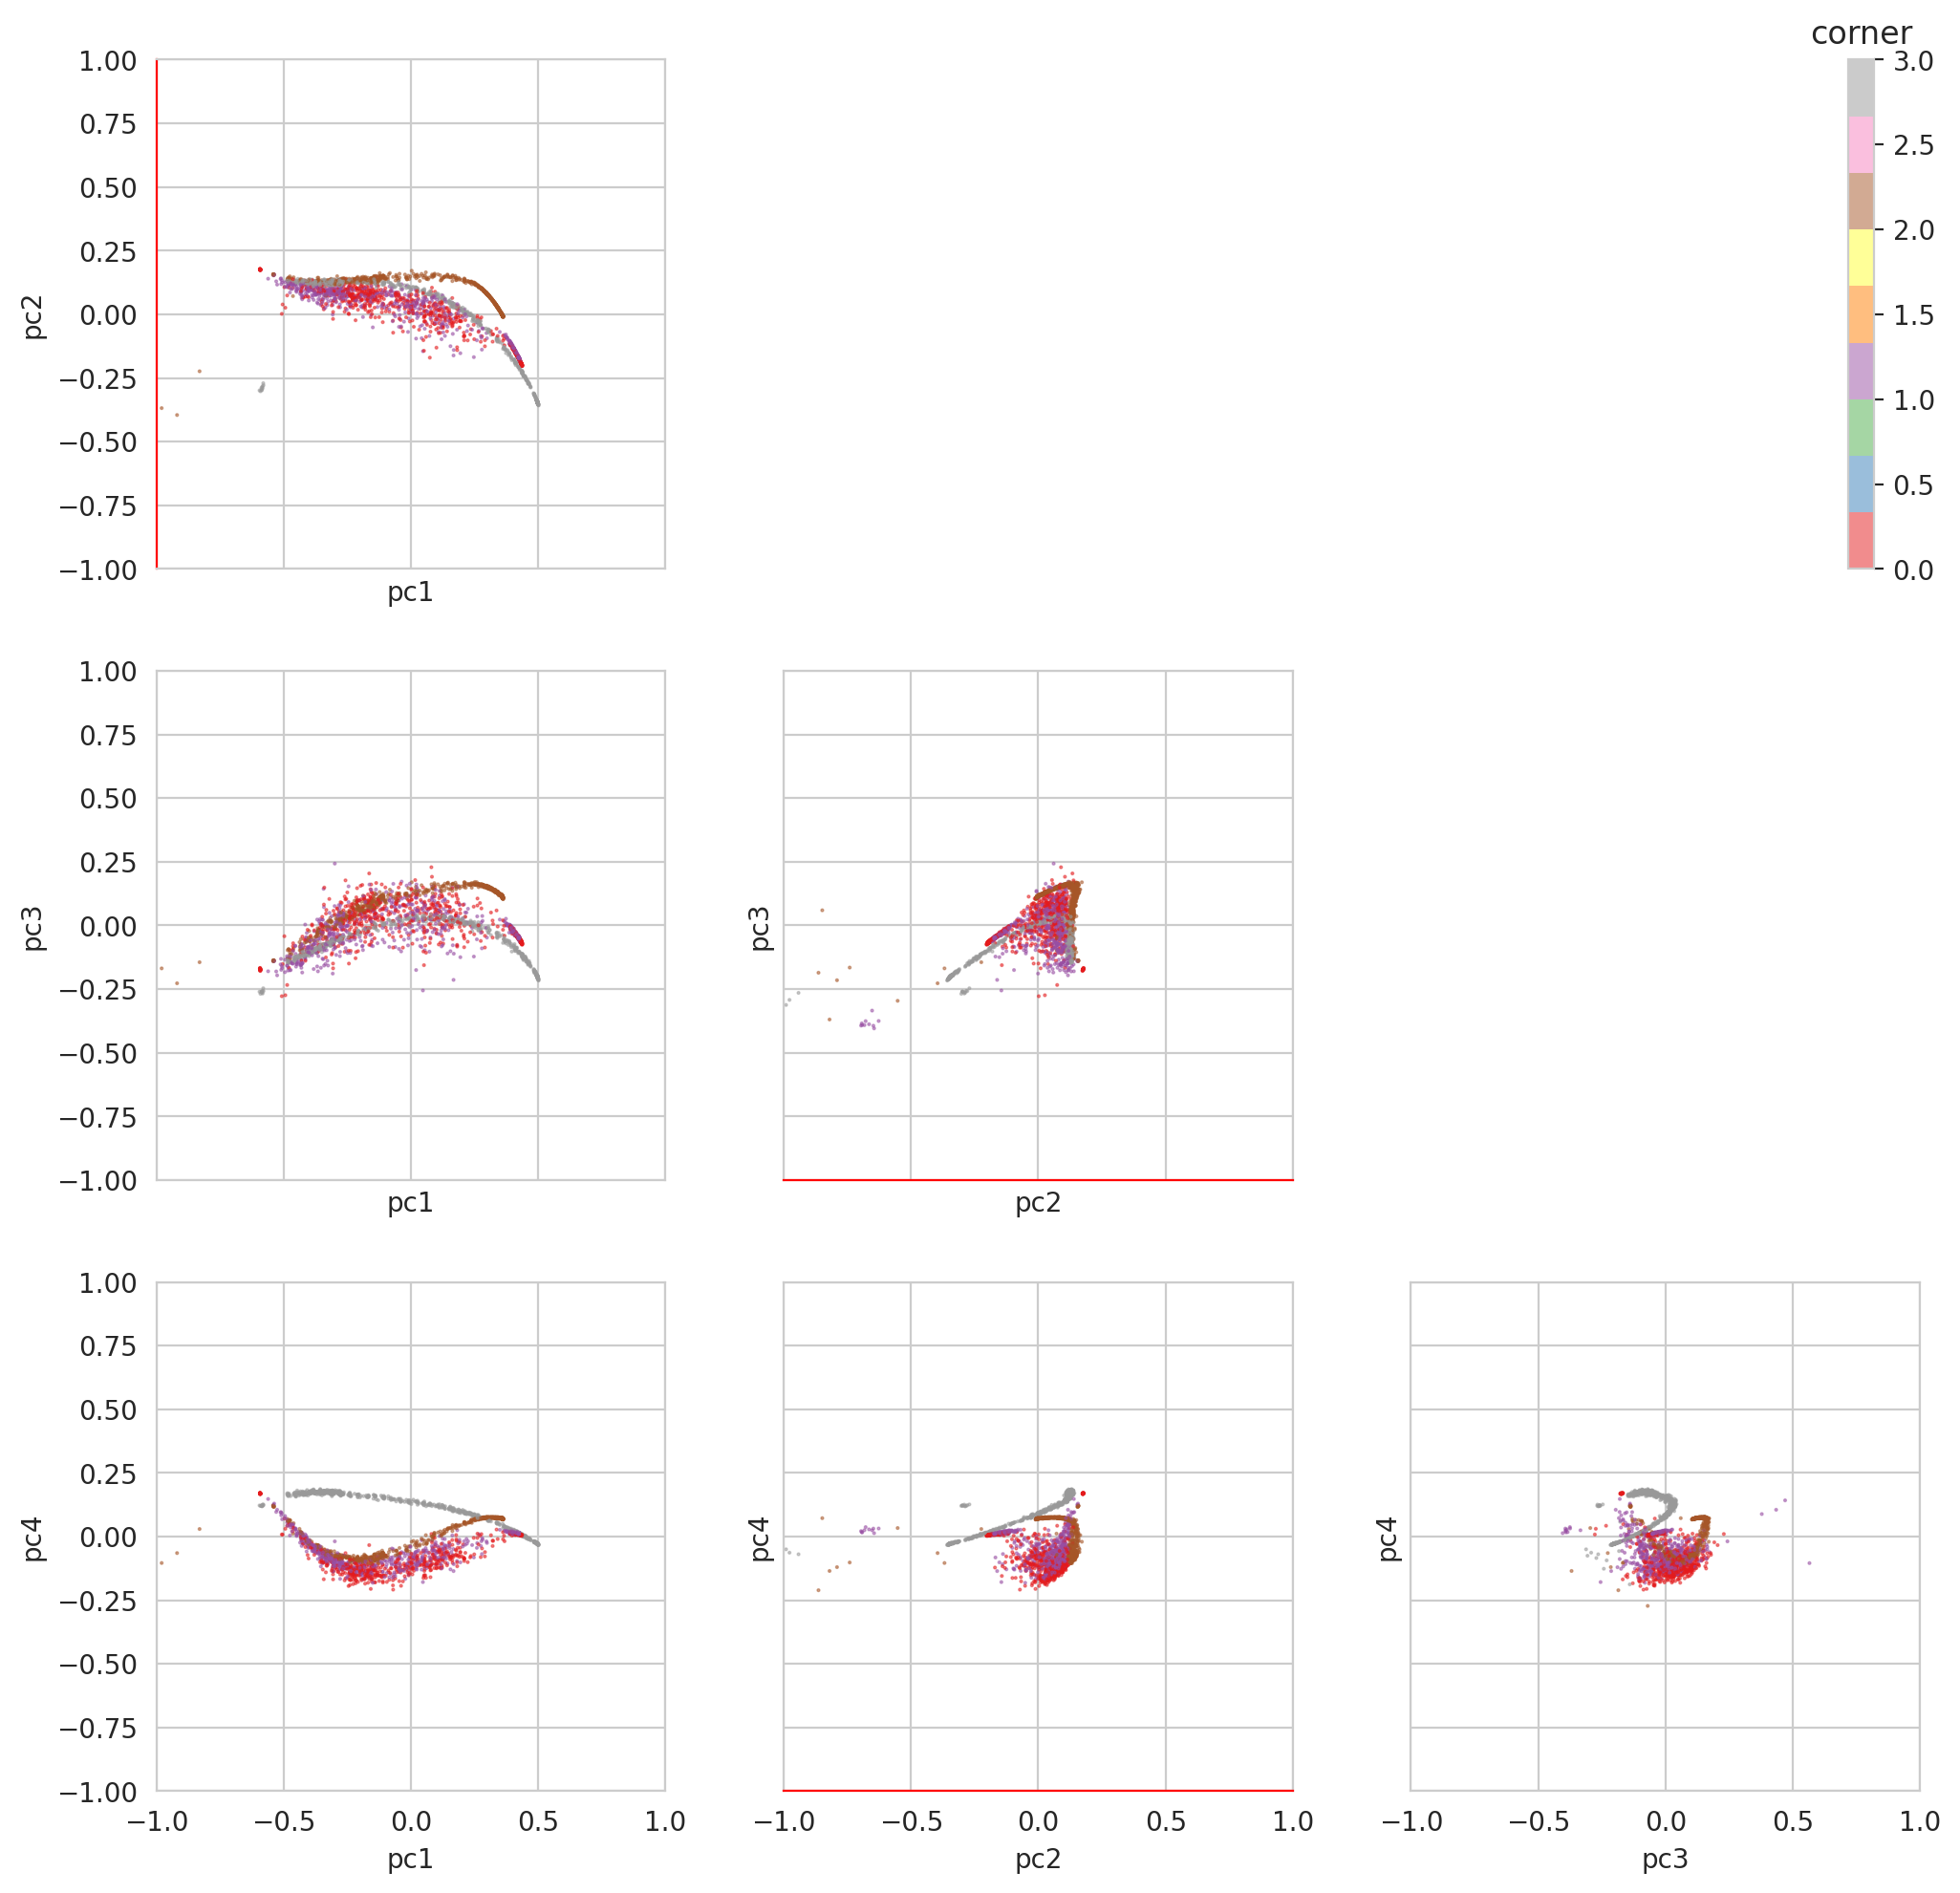

In [131]:
cmap = {f"corner: {c}": i for (i, c) in enumerate(['normal', 'uniform', 'subsample-200', 'subsample-2000'])} 
triplot(dc, r, d=4, key='aug', ckey='corner', cmap='Set1', cdict=cmap, sdict={},
            markers=["o", "x", "s", "*", "+"],
            evals=False, plot_avg=False
            )

[Text(0.5, 1.0, '1 - err')]

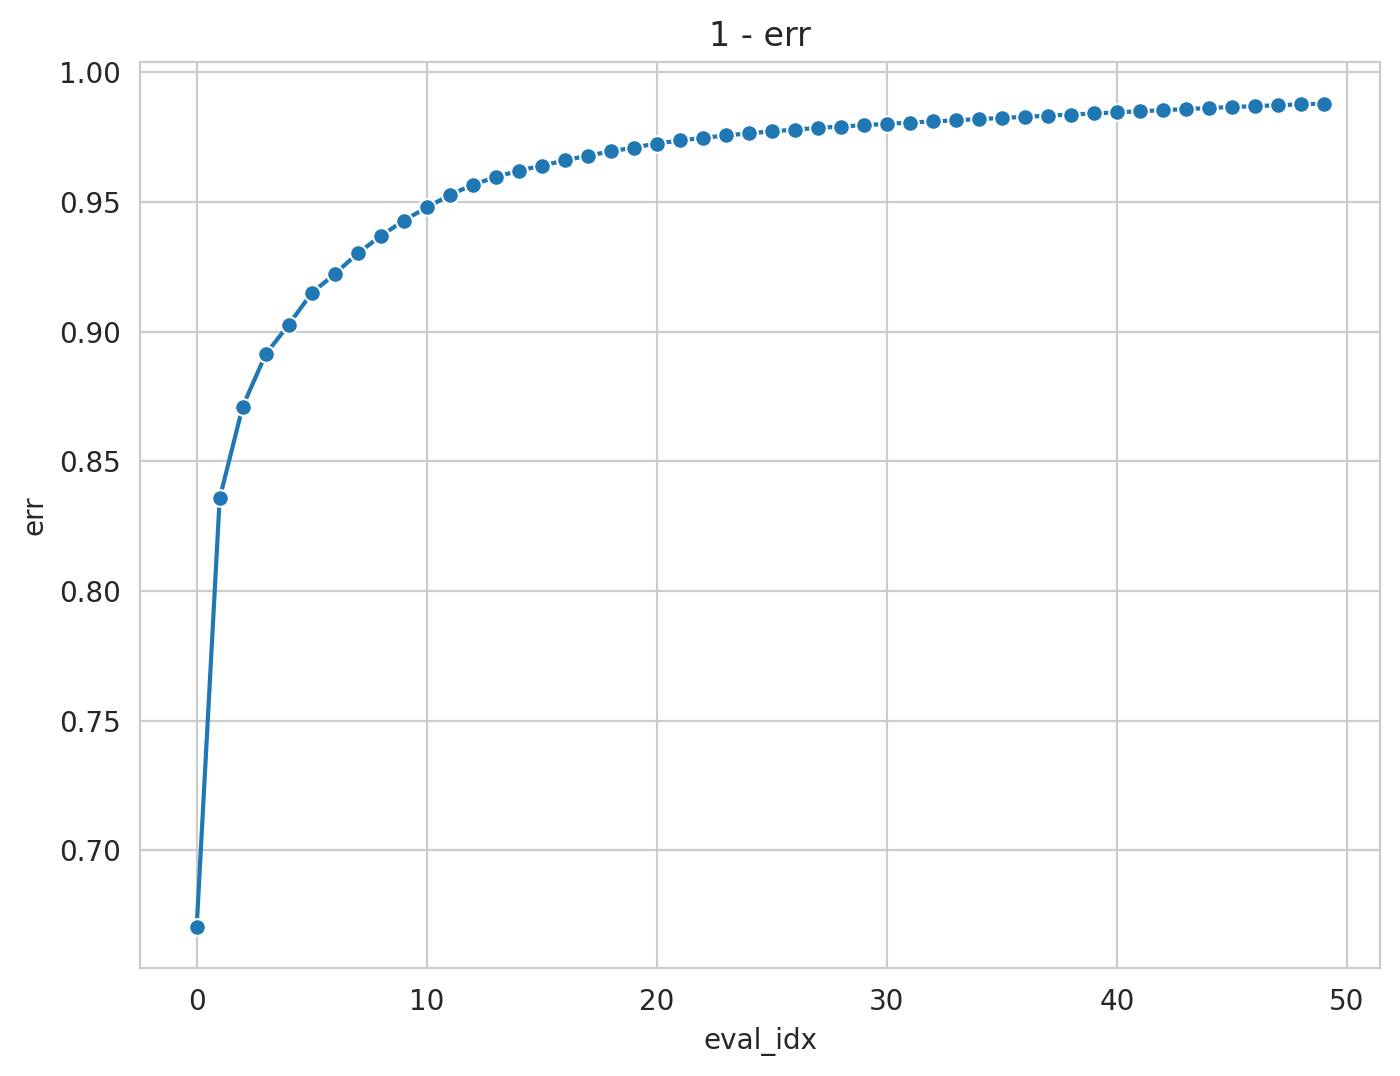

In [132]:
w = r['w']
import scipy.sparse.linalg as sp
ne = 50
es = sp.eigsh(w, ne, which='LM', return_eigenvectors=False)[::-1]
fn=np.linalg.norm(w, ord='fro')
df = pd.DataFrame(dict(eval_idx=np.arange(len(es)), err=1 - np.sqrt(1-np.cumsum(es ** 2)/fn**2)))
plt.figure(figsize=(8,6))
g=sns.lineplot(data=df, x='eval_idx', y='err', marker="o")
g.set(title="1 - err")

### all evals

#### Train Data

In [33]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all.p").reset_index(drop=True)

In [6]:
# idxs = []
for (config, ii) in didx.groupby(['m', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = didx.iloc[ii]['t'].max()
    didx.loc[ii, 't'] /= tmax
#     if didx.iloc[ii[-1]]['err'] < 0.1:
#         idxs.extend(ii)
# didx = didx.iloc[idxs].reset_index(drop=True)
# r['xp'] = r['xp'][idxs, :]

In [34]:
r['xp'] = np.vstack([r['xp'], r['extra_points']])[:-1, :]

In [36]:
from utils import dinpca
err = []
for i in range(7):
    dinpca_geod = dinpca(th.Tensor(r['xp'][-99:, :i]), 
                     th.Tensor(r['xp'][-99:, :i]),
                     th.Tensor(np.sign(r['e'][:i])),
                     dev='cpu').numpy()
    err.append(((dinpca_geod-wgeod)**2).sum() / (wgeod**2).sum())

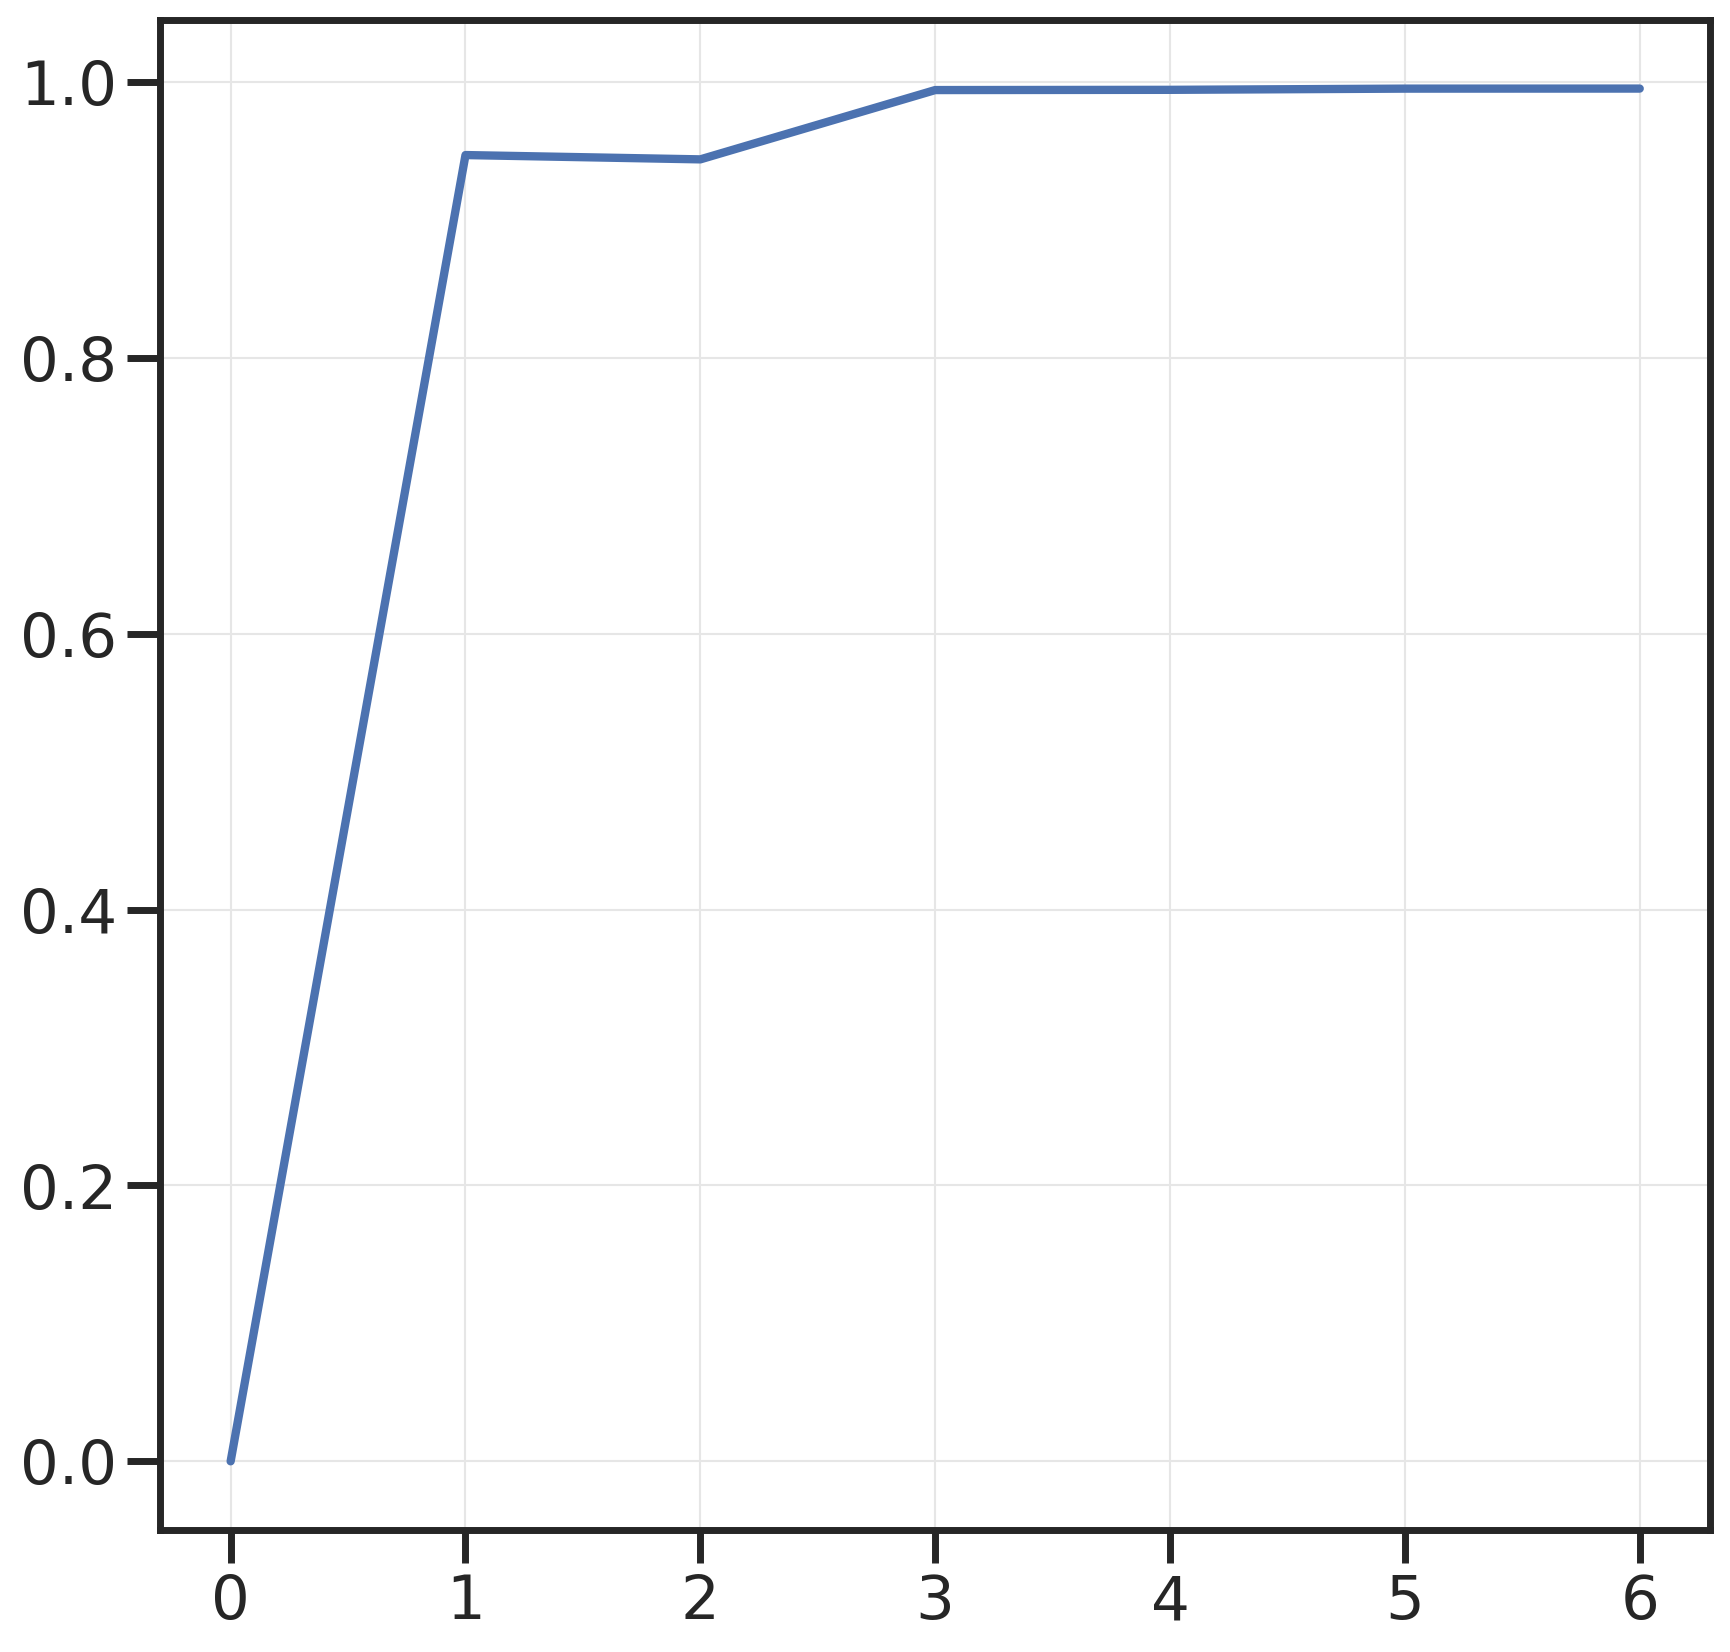

In [38]:
plt.plot([1-e for e in err])

In [ ]:
emph = [list(didx[didx.m=='geodesic'].index)]
fig, text, dc = plotly_3d(dc=didx.reset_index(drop=True), r=r, emph=emph, empsize=8,
                          colorscale='Viridis', 
                          ne=5, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='t',mode='markers', cmap=None, separate_traj=False, axis_range=[-1.5, 1.5])
fig.show()

/tmp/ipykernel_6289/27037418.py:71: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



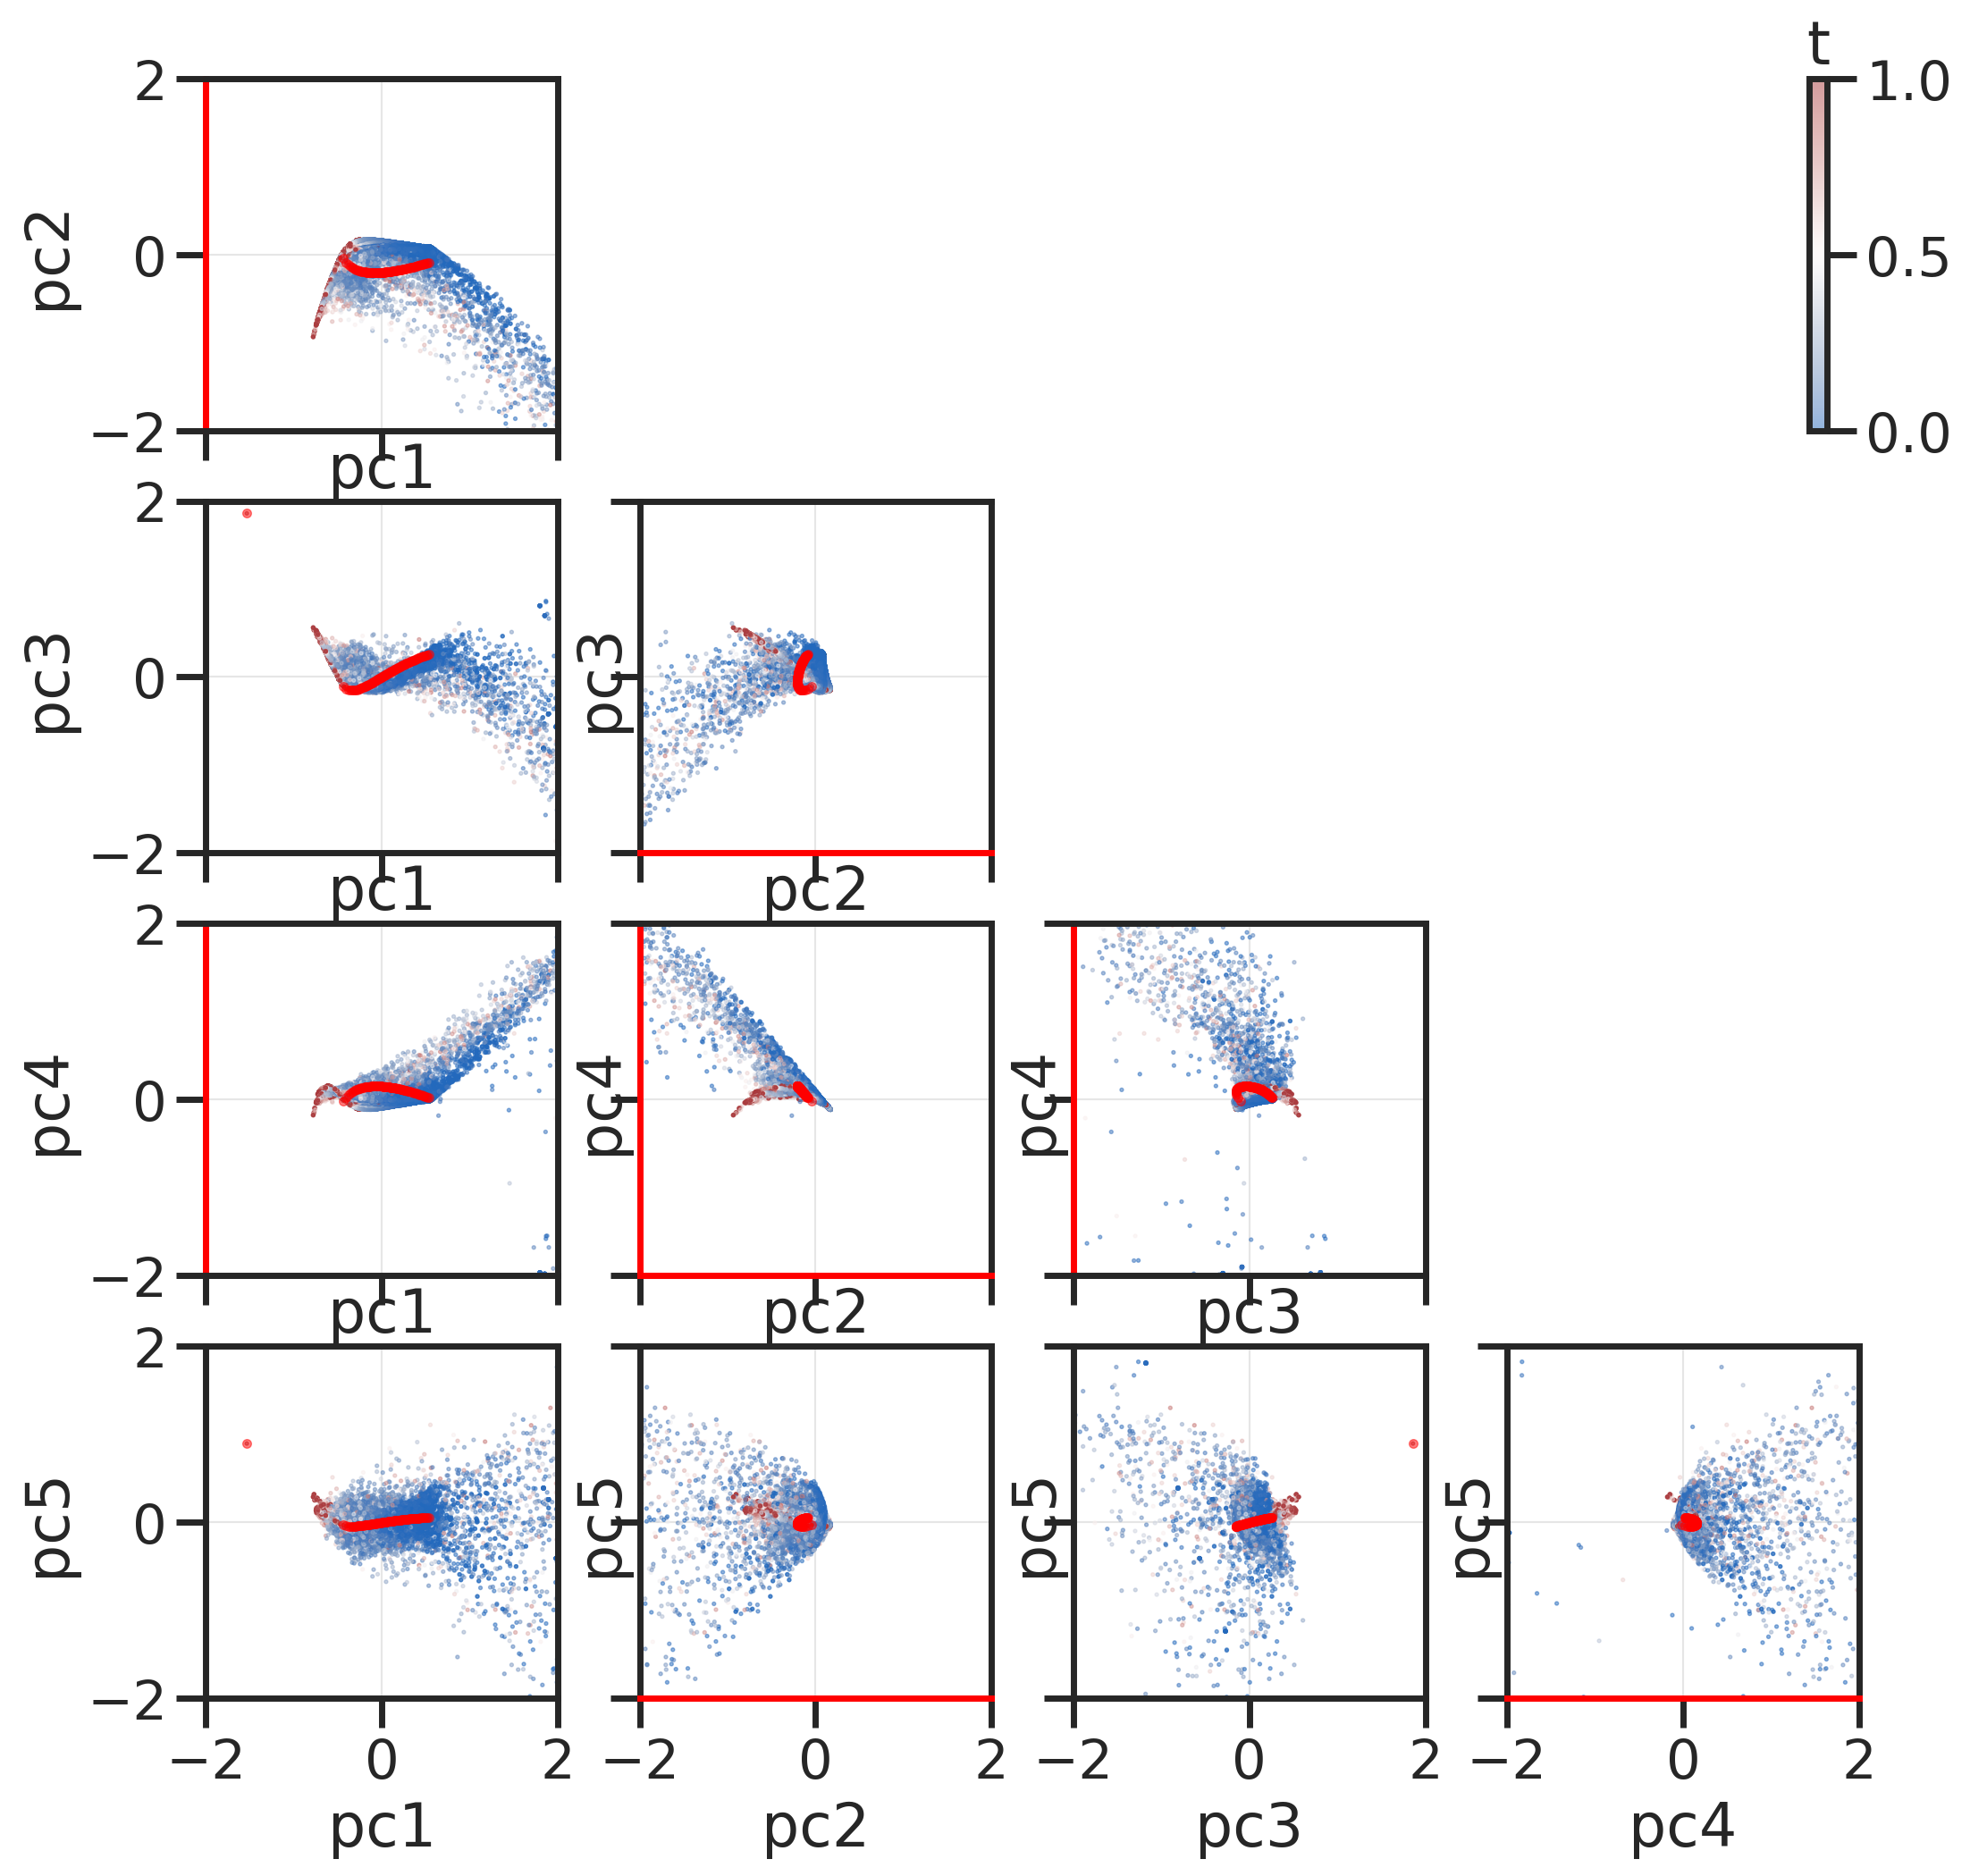

In [35]:
triplot(didx.reset_index(drop=True), r, emph=emph, d=5, cmap='vlag', cdict=None, ckey='t', 
            markers=["o", "x", "s", "*", "+"],
            evals=False, plot_avg=False, xrange=[-2, 2], yrange=[-2, 2]
            )

#### Train with Geod (included in embedding)

In [106]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all.p").reset_index(drop=True)

In [125]:
ii = np.argsort(r['es'])[::-1]
es = r['es'][ii]
vs = r['vs'][:, ii]
b = r['diag']
tr = r['tr']

df = []
for i in range(len(es)):
    tr = 2*(r['tr'] - es[:i].sum())**2
    bnorm = 2*len(vs)*((b - (es[:i]*(vs[:, :i]**2)).sum(1))**2).sum()
    Bf = 4*(r['fn']**2 - (es[:i]**2).sum())
    df.append(tr+bnorm+Bf)

In [132]:
r['xp'] = vs[:, :7] * np.sqrt(np.abs(es)[:7])

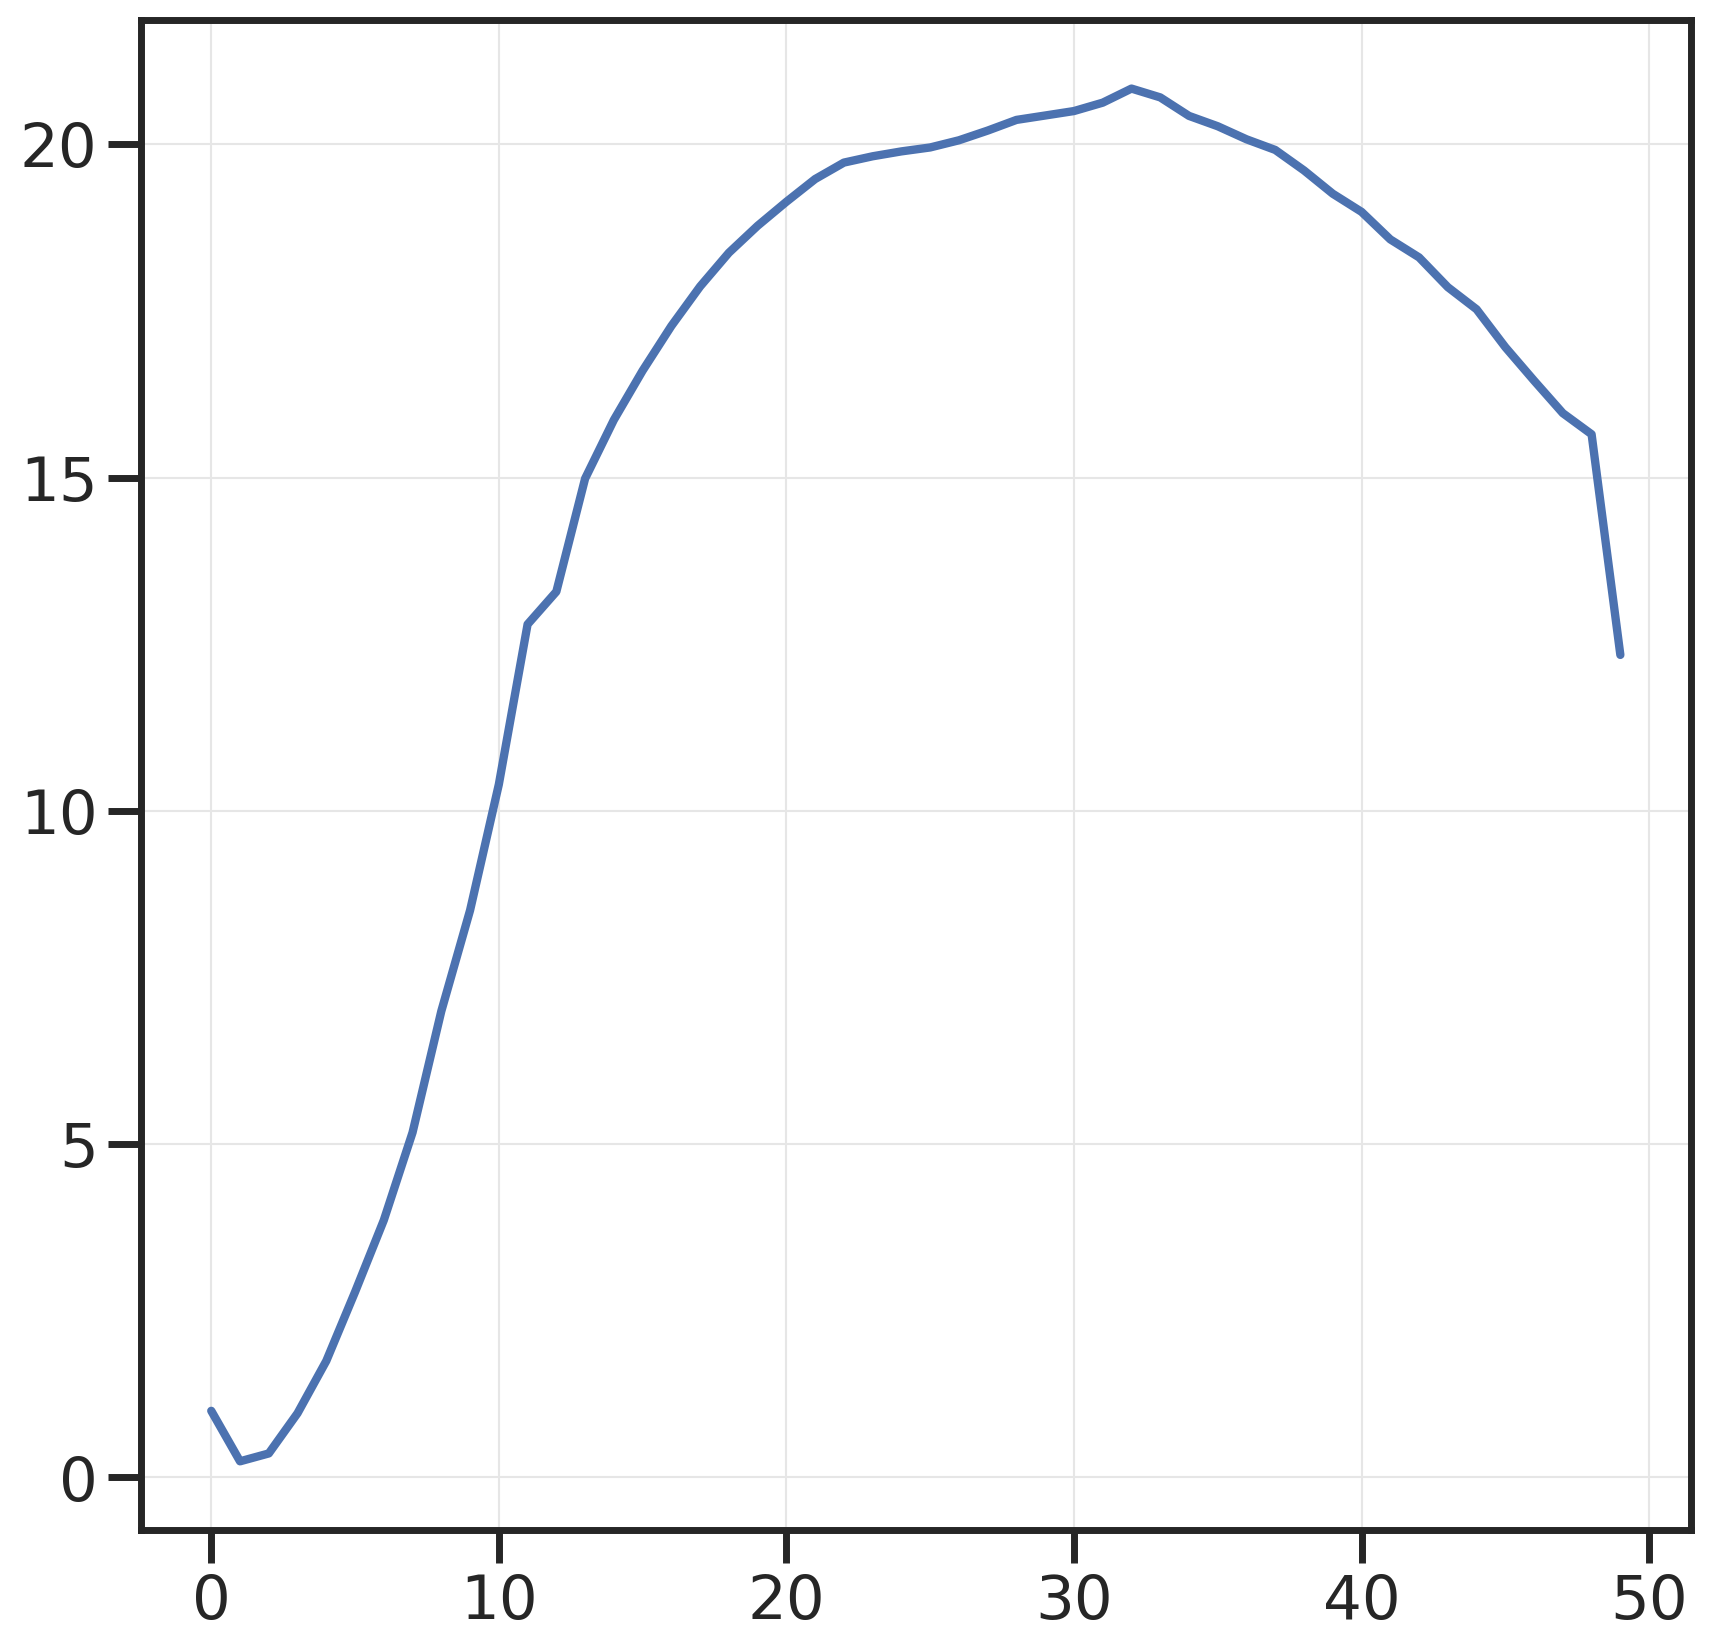

In [128]:
denom = 2*r['tr']**2 + 2*len(vs)*(r['diag']**2).sum() + 4*r['fn']**2
plt.plot(df/denom)

In [107]:
import h5py
f = h5py.File(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all_geod.h5', 'r')
w = f['w']

In [115]:
from utils import dinpca
err = []
col = slice(0, 100)
row = slice(0, 100)
wi = wall[row, col]
for i in range(7):
    dinpca_geod = dinpca(th.Tensor(r['xp'][col, :i]), 
                     th.Tensor(r['xp'][row, :i]),
                     th.Tensor(np.sign(r['e'][:i])),
                     dev='cpu').numpy()
    err.append(((dinpca_geod-wi)**2).sum() / (wi**2).sum())

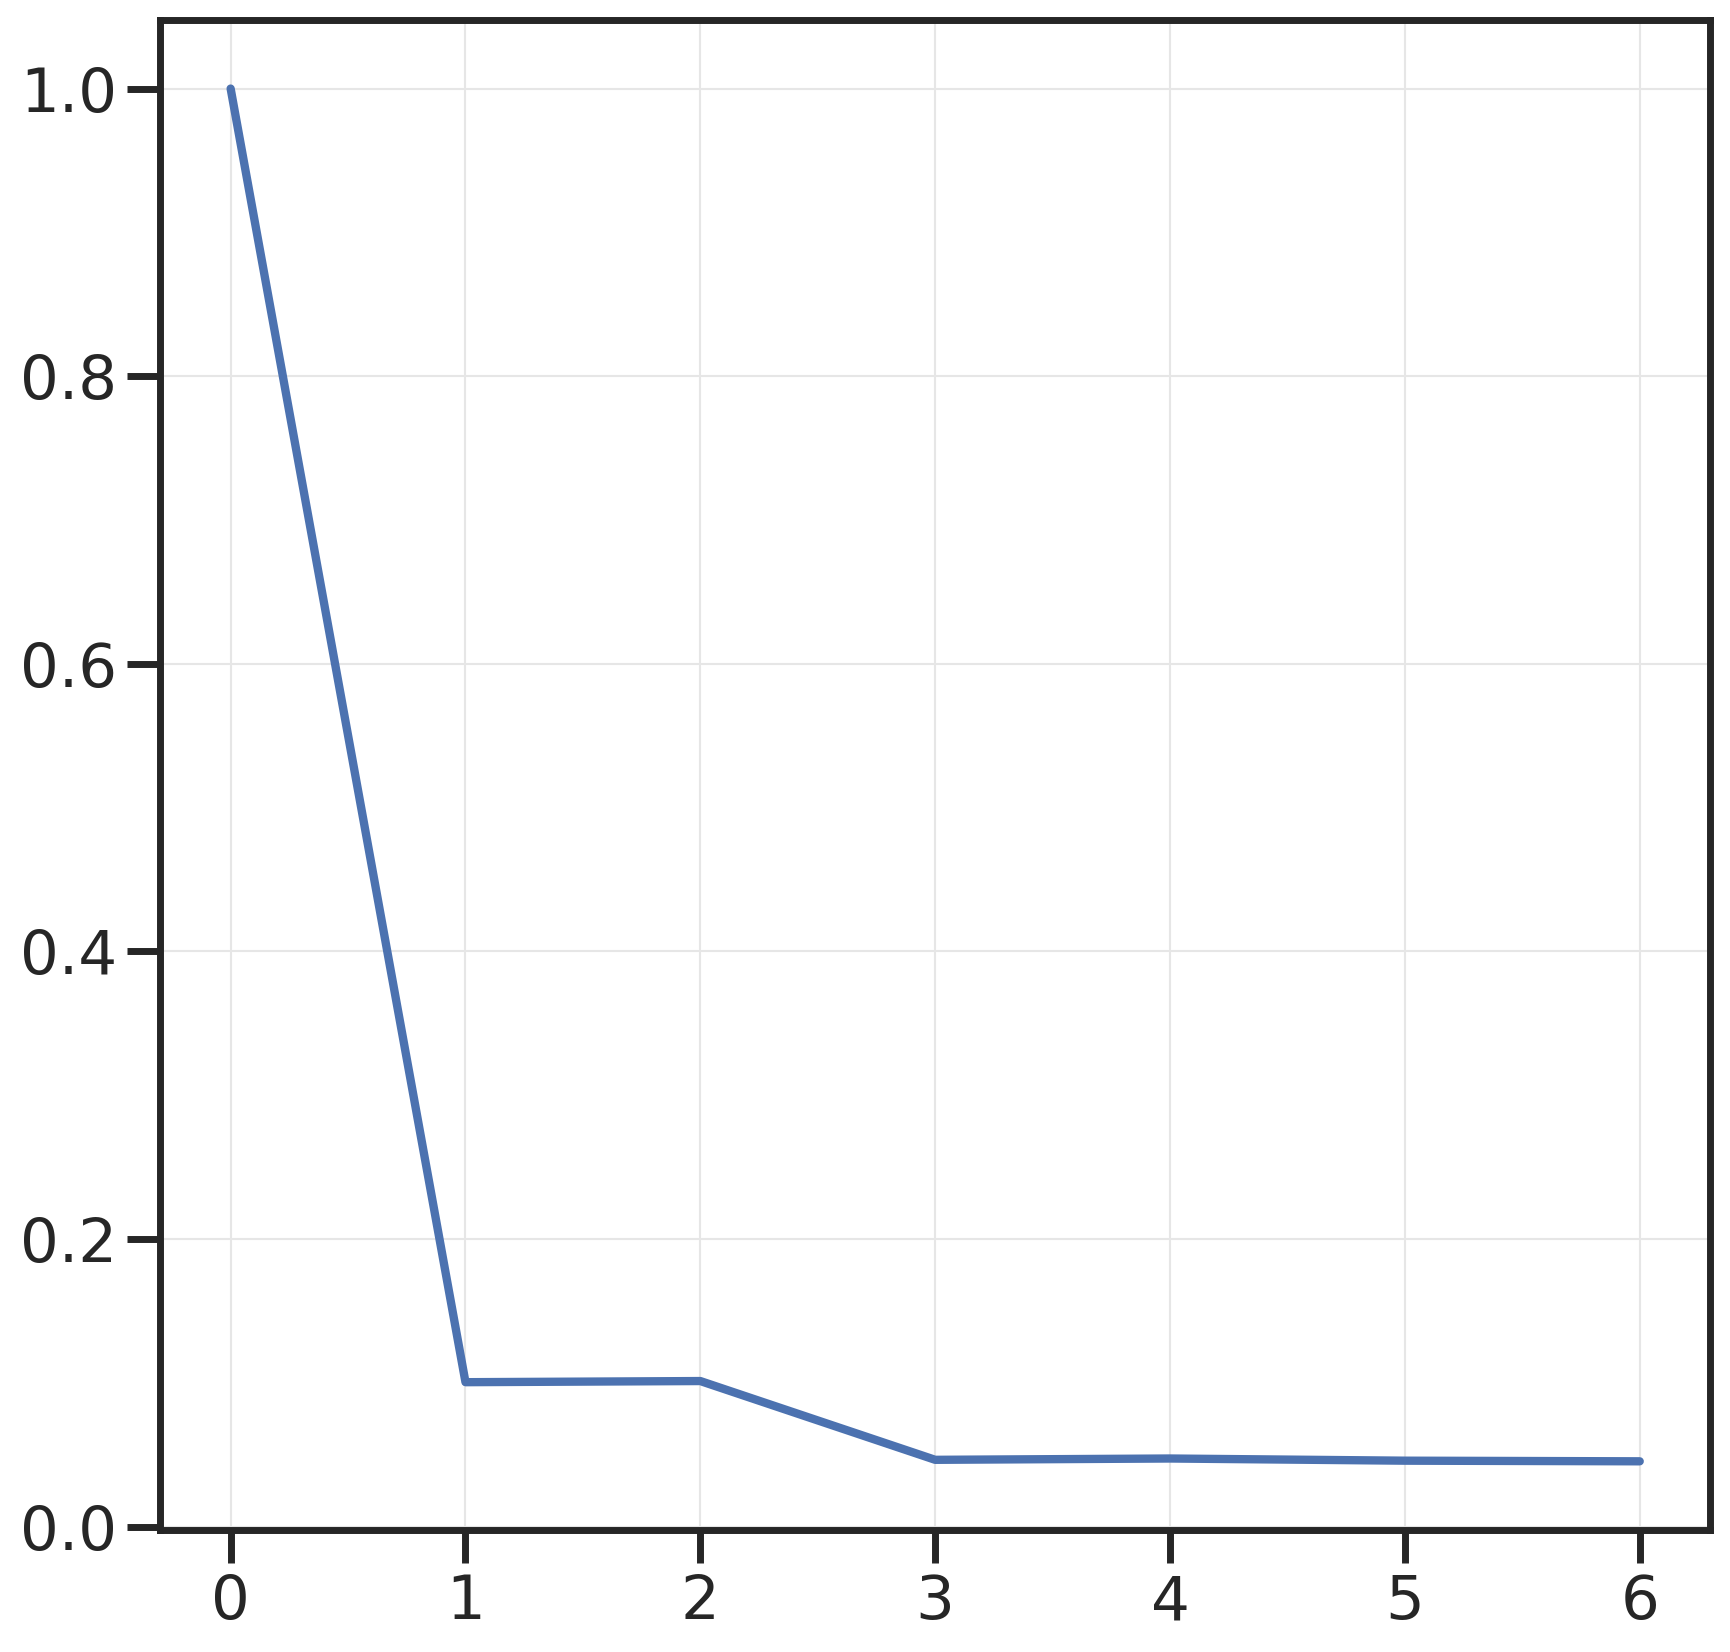

In [129]:
plt.plot(err)

In [59]:
# idxs = []
for (config, ii) in didx.groupby(['m', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = didx.iloc[ii]['t'].max()
    didx.loc[ii, 't'] /= tmax
#     if didx.iloc[ii[-1]]['err'] < 0.1:
#         idxs.extend(ii)
# didx = didx.iloc[idxs].reset_index(drop=True)
# r['xp'] = r['xp'][idxs, :]

In [60]:
r['xp'].shape

(151506, 7)

In [21]:
idxs = []
for (config, ii) in didx.groupby(['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = didx.iloc[ii]['t'].max()
    didx.loc[ii, 't'] /= tmax
    if didx.iloc[ii[-1]]['err'] < 0.1:
        idxs.extend(ii)
dd = didx.iloc[idxs].reset_index(drop=True)
r['xp'] = r['xp'][idxs, :]

In [79]:
p = r['xp'][-1, :]

In [80]:
u = np.linspace(0, 5, 240)
v = np.linspace(0, 2 * np.pi, 240)
uGrid, vGrid = np.meshgrid(u, v)

x = uGrid * np.cos(vGrid) + p[0]
y = uGrid + p[1]
z = uGrid * np.sin(vGrid) + p[2]

In [ ]:
emph = [list(didx[didx.m=='geodesic'].index)]
fig, text, dc = plotly_3d(dc=didx.reset_index(drop=True), r=r, emph=emph, empsize=4, colorscale='Viridis', 
                          ne=5, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='t',mode='markers', cmap=None, separate_traj=False, axis_range=[-5, 5])
fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))
fig.show()

In [ ]:
emph = [list(didx[didx.m=='geodesic'].index)]
fig, text, dc = plotly_3d(dc=didx.reset_index(drop=True), r=r, emph=emph, empsize=4, colorscale='Viridis', 
                          ne=5, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='t',mode='markers', cmap=None, separate_traj=False, axis_range=[-5, 5])
fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))
fig.show()

In [ ]:
emph = [list(didx[didx.m=='geodesic'].index)]
didx['d2pstar'] = w[-1, :]
didx['d2p0'] = w[-99, :]
fig, text, dc = plotly_3d(dc=didx.reset_index(drop=True), r=r, emph=emph, empsize=4, colorscale='Viridis', 
                          ne=5, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='d2pstar',mode='markers', cmap=None, separate_traj=False, axis_range=[-5, 5])
fig.show()

In [ ]:
fig, text, dc = plotly_3d(dc=didx.reset_index(drop=True), r=r, emph=emph, empsize=4, colorscale='Viridis', 
                          ne=5, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='d2p0',mode='markers', cmap=None, separate_traj=False, axis_range=[-5, 5])
fig.show()

/tmp/ipykernel_7054/27037418.py:71: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



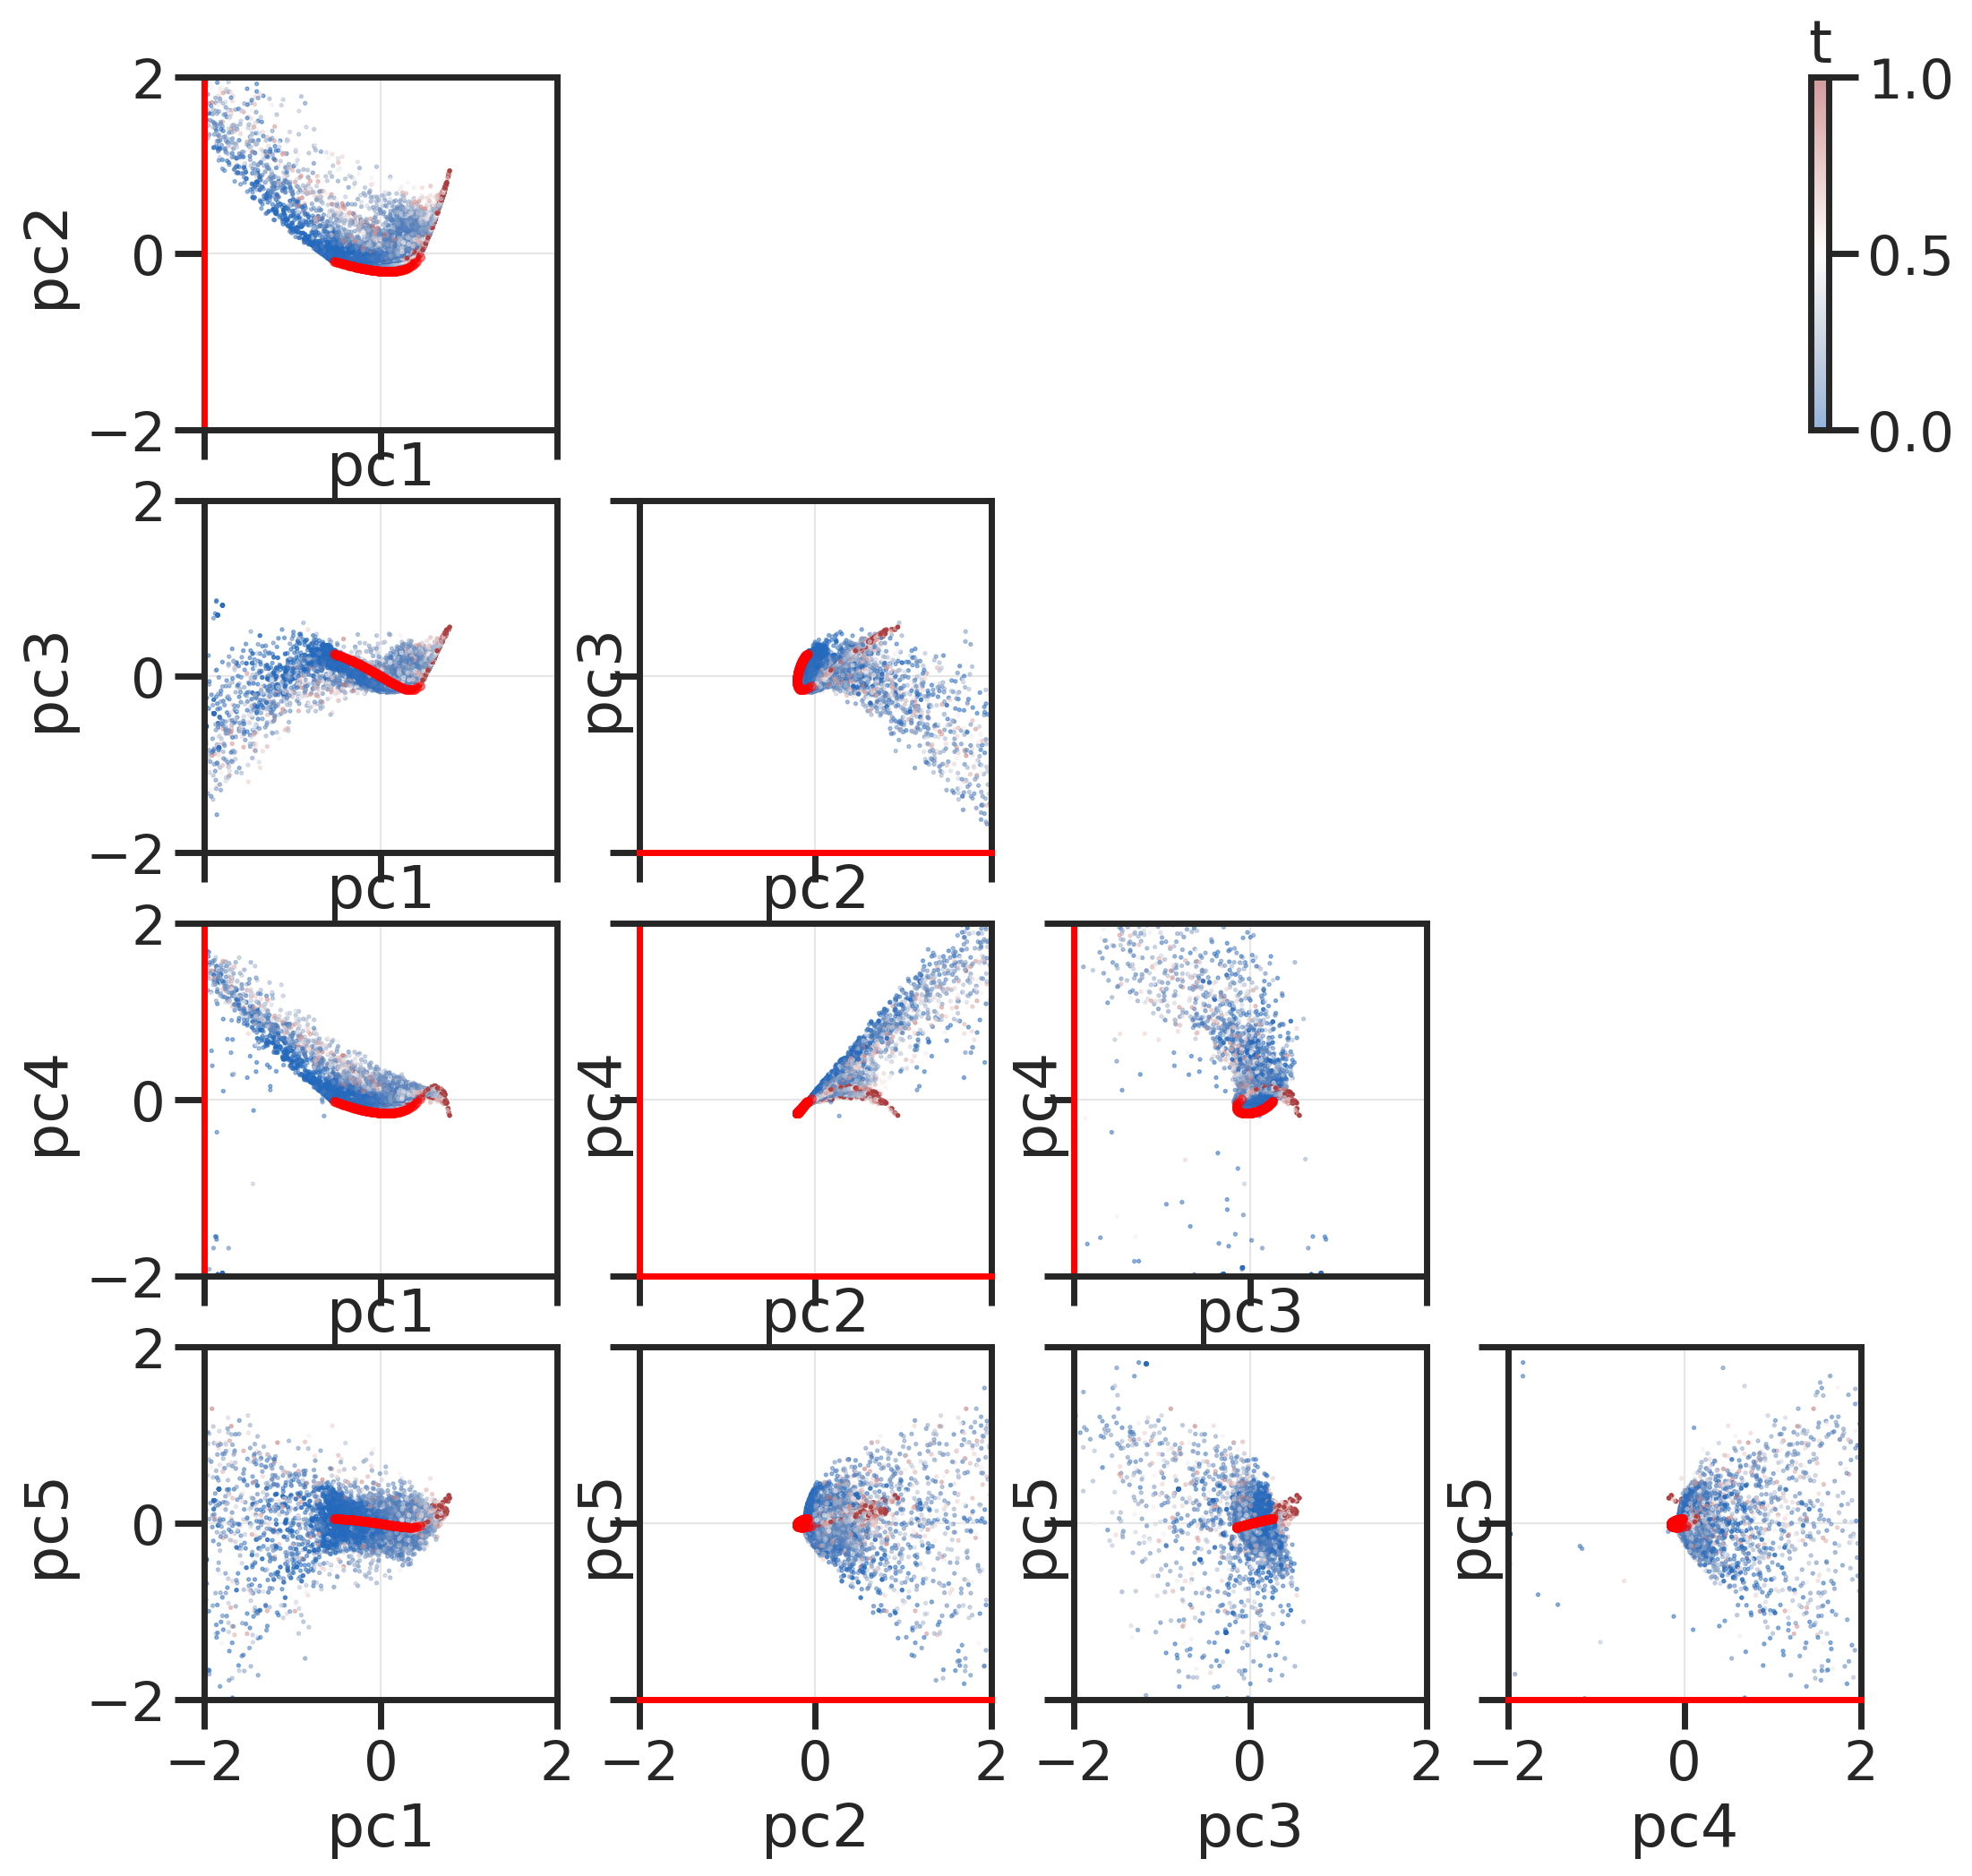

In [65]:
triplot(didx.reset_index(drop=True), r, emph=emph, d=5, cmap='vlag', cdict=None, ckey='t', 
            markers=["o", "x", "s", "*", "+"],
            evals=False, plot_avg=False, xrange=[-2, 2], yrange=[-2, 2]
            )

#### Test with Geod (included in embedding)

In [38]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yvh_all_geod.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all.p").reset_index(drop=True)

In [91]:
p = r['xp'][-1, :]
u = np.linspace(-5, 5, 240)
v = np.linspace(0, 2 * np.pi, 240)
uGrid, vGrid = np.meshgrid(u, v)

x = uGrid * np.cos(vGrid) + p[0]
y = uGrid + p[1]
z = uGrid * np.sin(vGrid) + p[2]

surface = go.Surface(x=x, y=y, z=z, opacity=0.5)

In [ ]:
emph = [list(didx[didx.m=='geodesic'].index)]
fig, text, dc = plotly_3d(dc=dd.reset_index(drop=True), r=r_, emph=emph, empmode='markers', empsize=8,
                          colorscale='Viridis', 
                          ne=5, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='t',mode='markers', cmap=None, separate_traj=False, axis_range=[-1.5, 1.5])
fig.add_trace(surface)
fig.show()

In [27]:
xx = r['xp']
dd = didx
for (config, ii) in didx.groupby(['m', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = dd.iloc[ii]['t'].max()
    dd.loc[ii, 't'] /= tmax
    di = dd.iloc[ii]
    for t in di.t.unique():
        ti = get_idx(di, f"t=={t}")
        xx = np.vstack([xx, xx[ti, :].mean(0, keepdims=True)])
        dd = pd.concat([dd, pd.DataFrame([list(config) + [0, t]], 
                            columns=['m', 'opt', 'bs', 'aug', 'lr', 'wd', 'seed', 't'])])

In [ ]:
# emph = [list(np.arange(len(didx), len(dd)))]
emph = [list(didx[didx.m=='geodesic'].index)]
# r_ = r
# r_['xp'] = xx
fig, text, dc = plotly_3d(dc=dd.reset_index(drop=True), r=r_, emph=emph, empmode='markers', empsize=8,
                          colorscale='Viridis', 
                          ne=5, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='t',mode='markers', cmap=None, separate_traj=False, axis_range=[-1.5, 1.5])
fig.show()

/tmp/ipykernel_6289/27037418.py:71: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



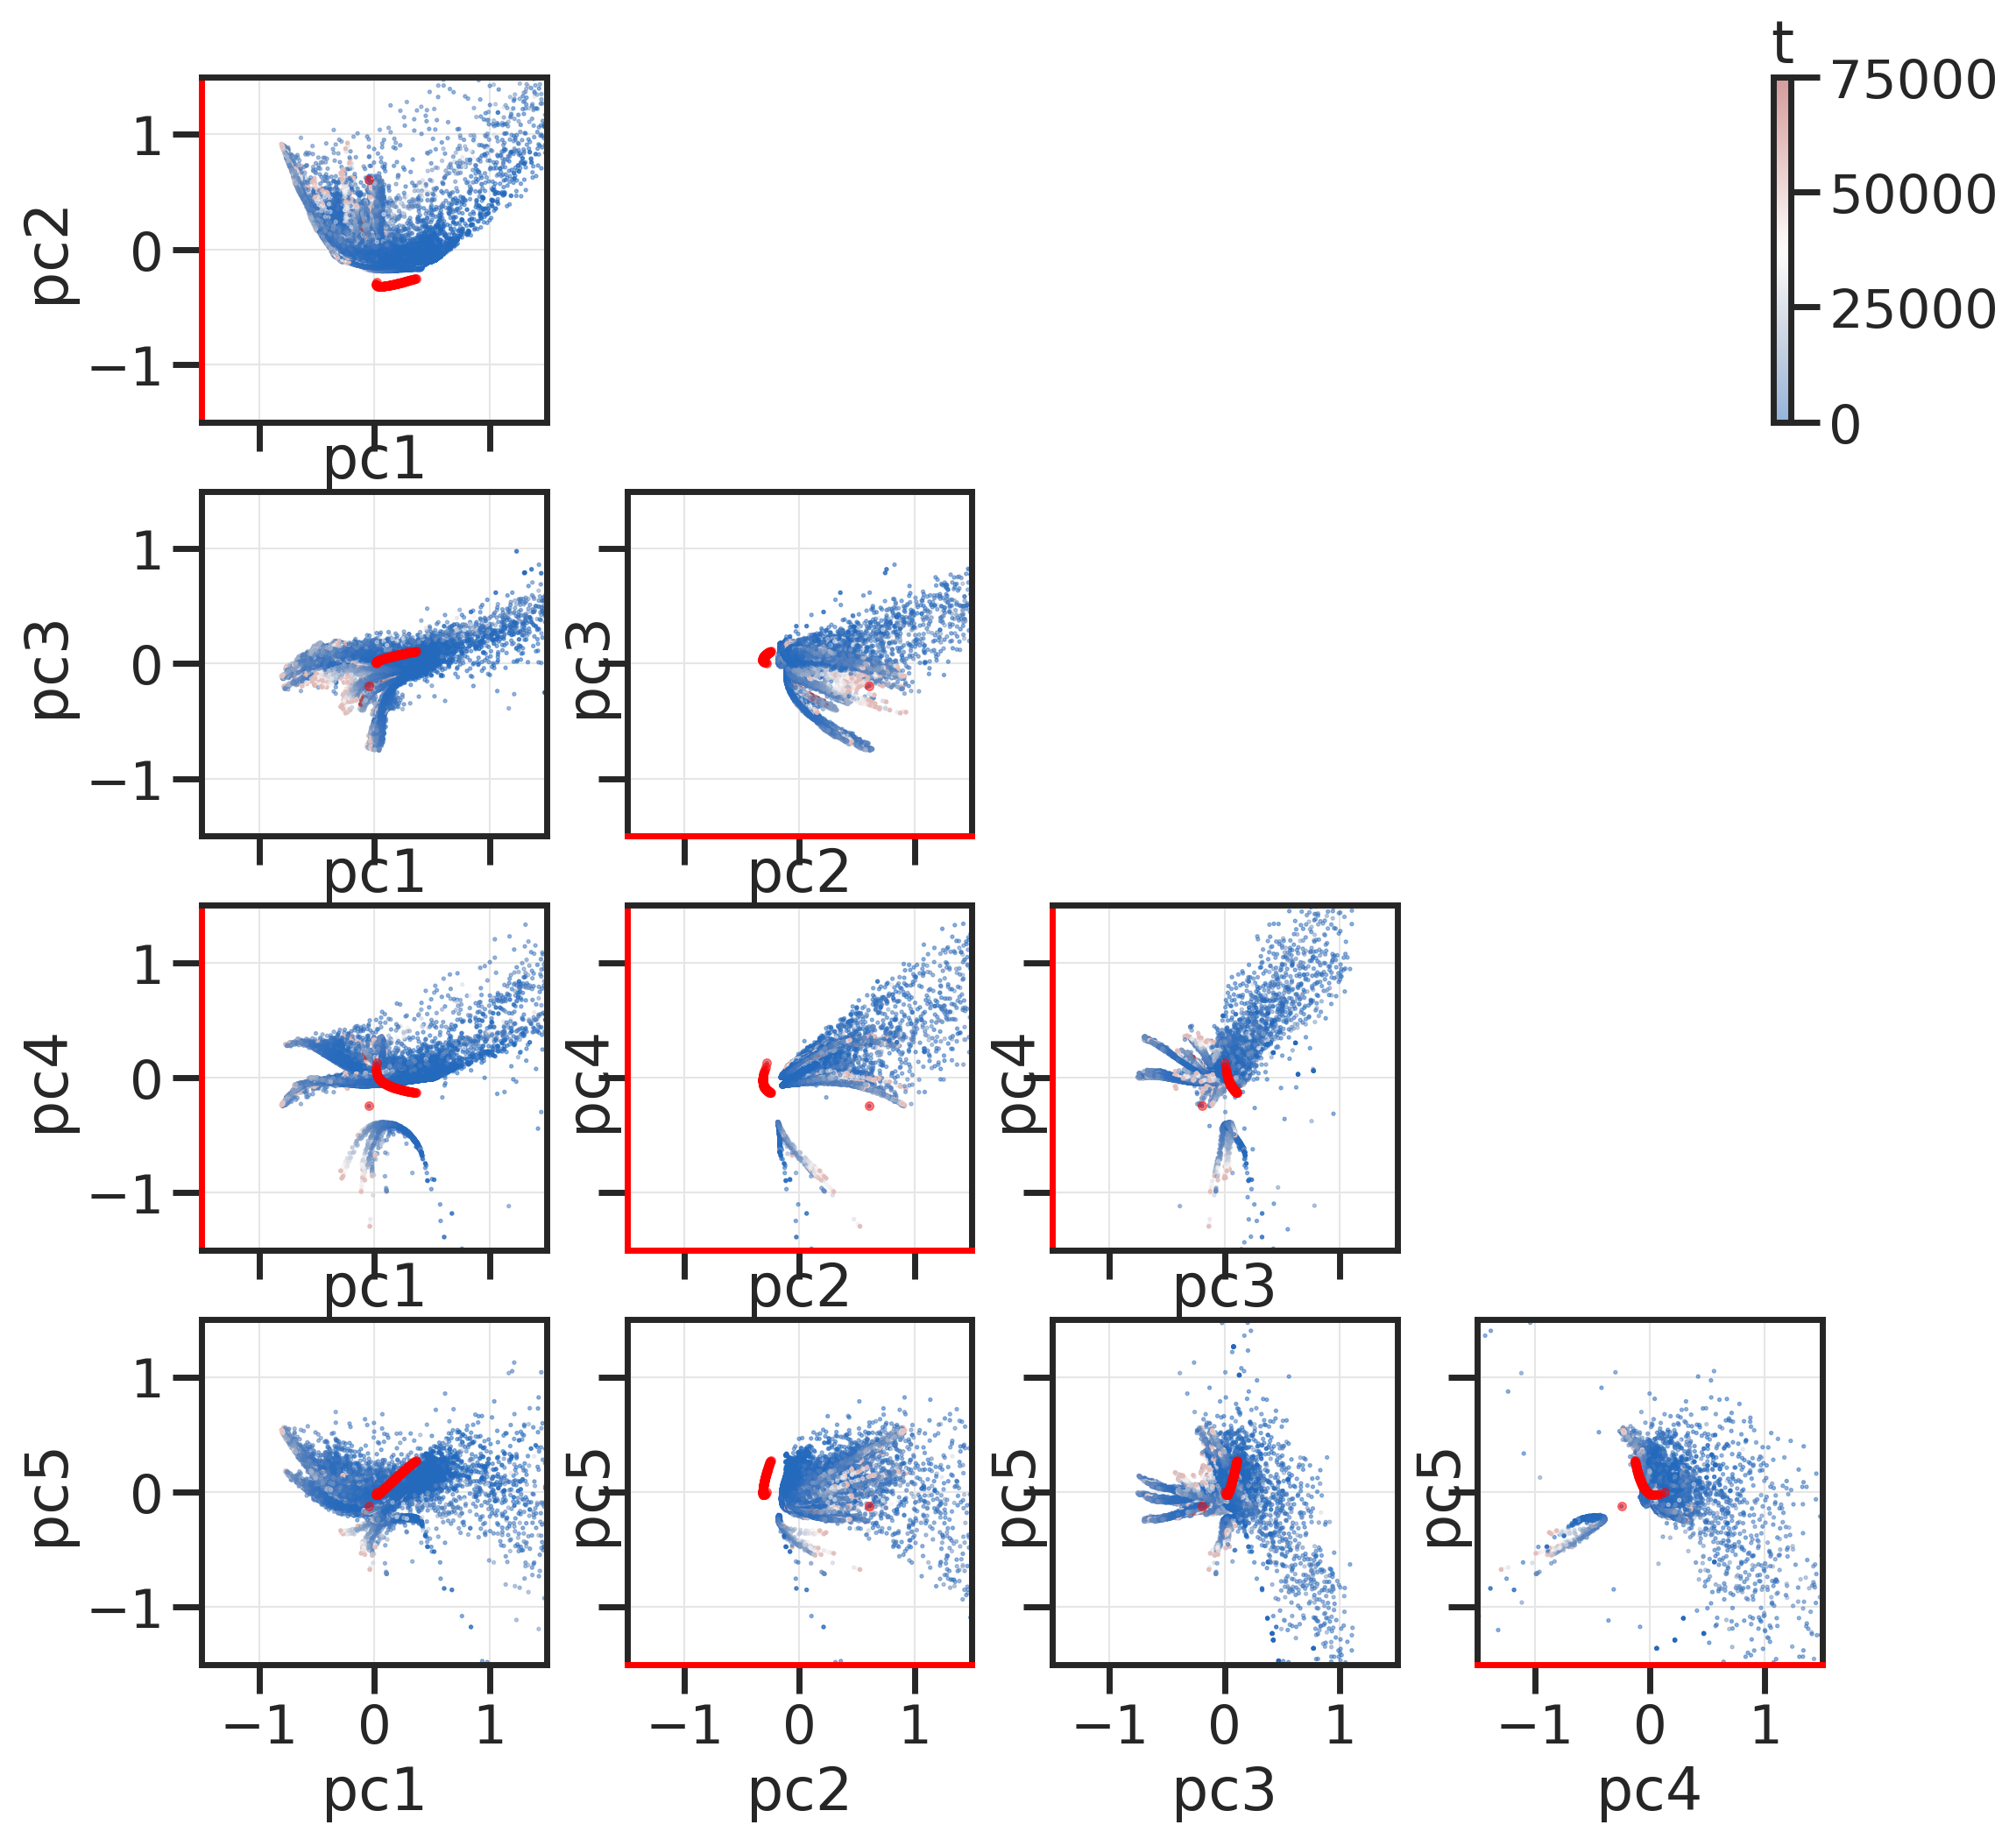

In [42]:
triplot(didx.reset_index(drop=True), r, emph=emph, d=5, cmap='vlag', cdict=None, ckey='t', 
            markers=["o", "x", "s", "*", "+"],
            evals=False, plot_avg=False, xrange=[-1.5, 1.5], yrange=[-1.5, 1.5]
            )

#### Val Data

In [36]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yvh_all.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_yvh_all.p").reset_index(drop=False)

In [37]:
idxs = []
for (config, ii) in didx.groupby(['m', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = didx.iloc[ii]['t'].max()
    didx.loc[ii, 't'] /= tmax
#     if didx.iloc[ii[-1]]['err'] < 0.1 and (didx.iloc[ii]['opt'] != 'adam').all():
#         idxs.extend(ii)
# didx = didx.iloc[idxs]
# r['xp'] = r['xp'][idxs, :]

In [135]:
xx = r['xp']
dd = didx
emph = []
for (config, ii) in didx.groupby(['m', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = dd.iloc[ii]['t'].max()
    dd.loc[ii, 't'] /= tmax
    di = dd.iloc[ii]
    emph.append(list(range(len(xx), len(xx)+len(di.t.unique()))))
    for t in di.t.unique():
        ti = get_idx(di, f"t=={t}")
        xx = np.vstack([xx, xx[ti, :].mean(0, keepdims=True)])
        dd = pd.concat([dd, pd.DataFrame([list(config) + [0, t]], 
                            columns=['m', 'opt', 'bs', 'aug', 'lr', 'wd', 'seed', 't'])])


In [ ]:
r_ = r
r_['xp'] = xx
fig, text, dc = plotly_3d(dc=dd.reset_index(drop=True), r=r_, emph=emph, empmode='lines', empsize=8,
                          colorscale='Viridis', 
                          ne=5, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='t',mode='markers', cmap=None, separate_traj=False, axis_range=[-1.5, 1.5])
fig.show()

/tmp/ipykernel_36739/27037418.py:71: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



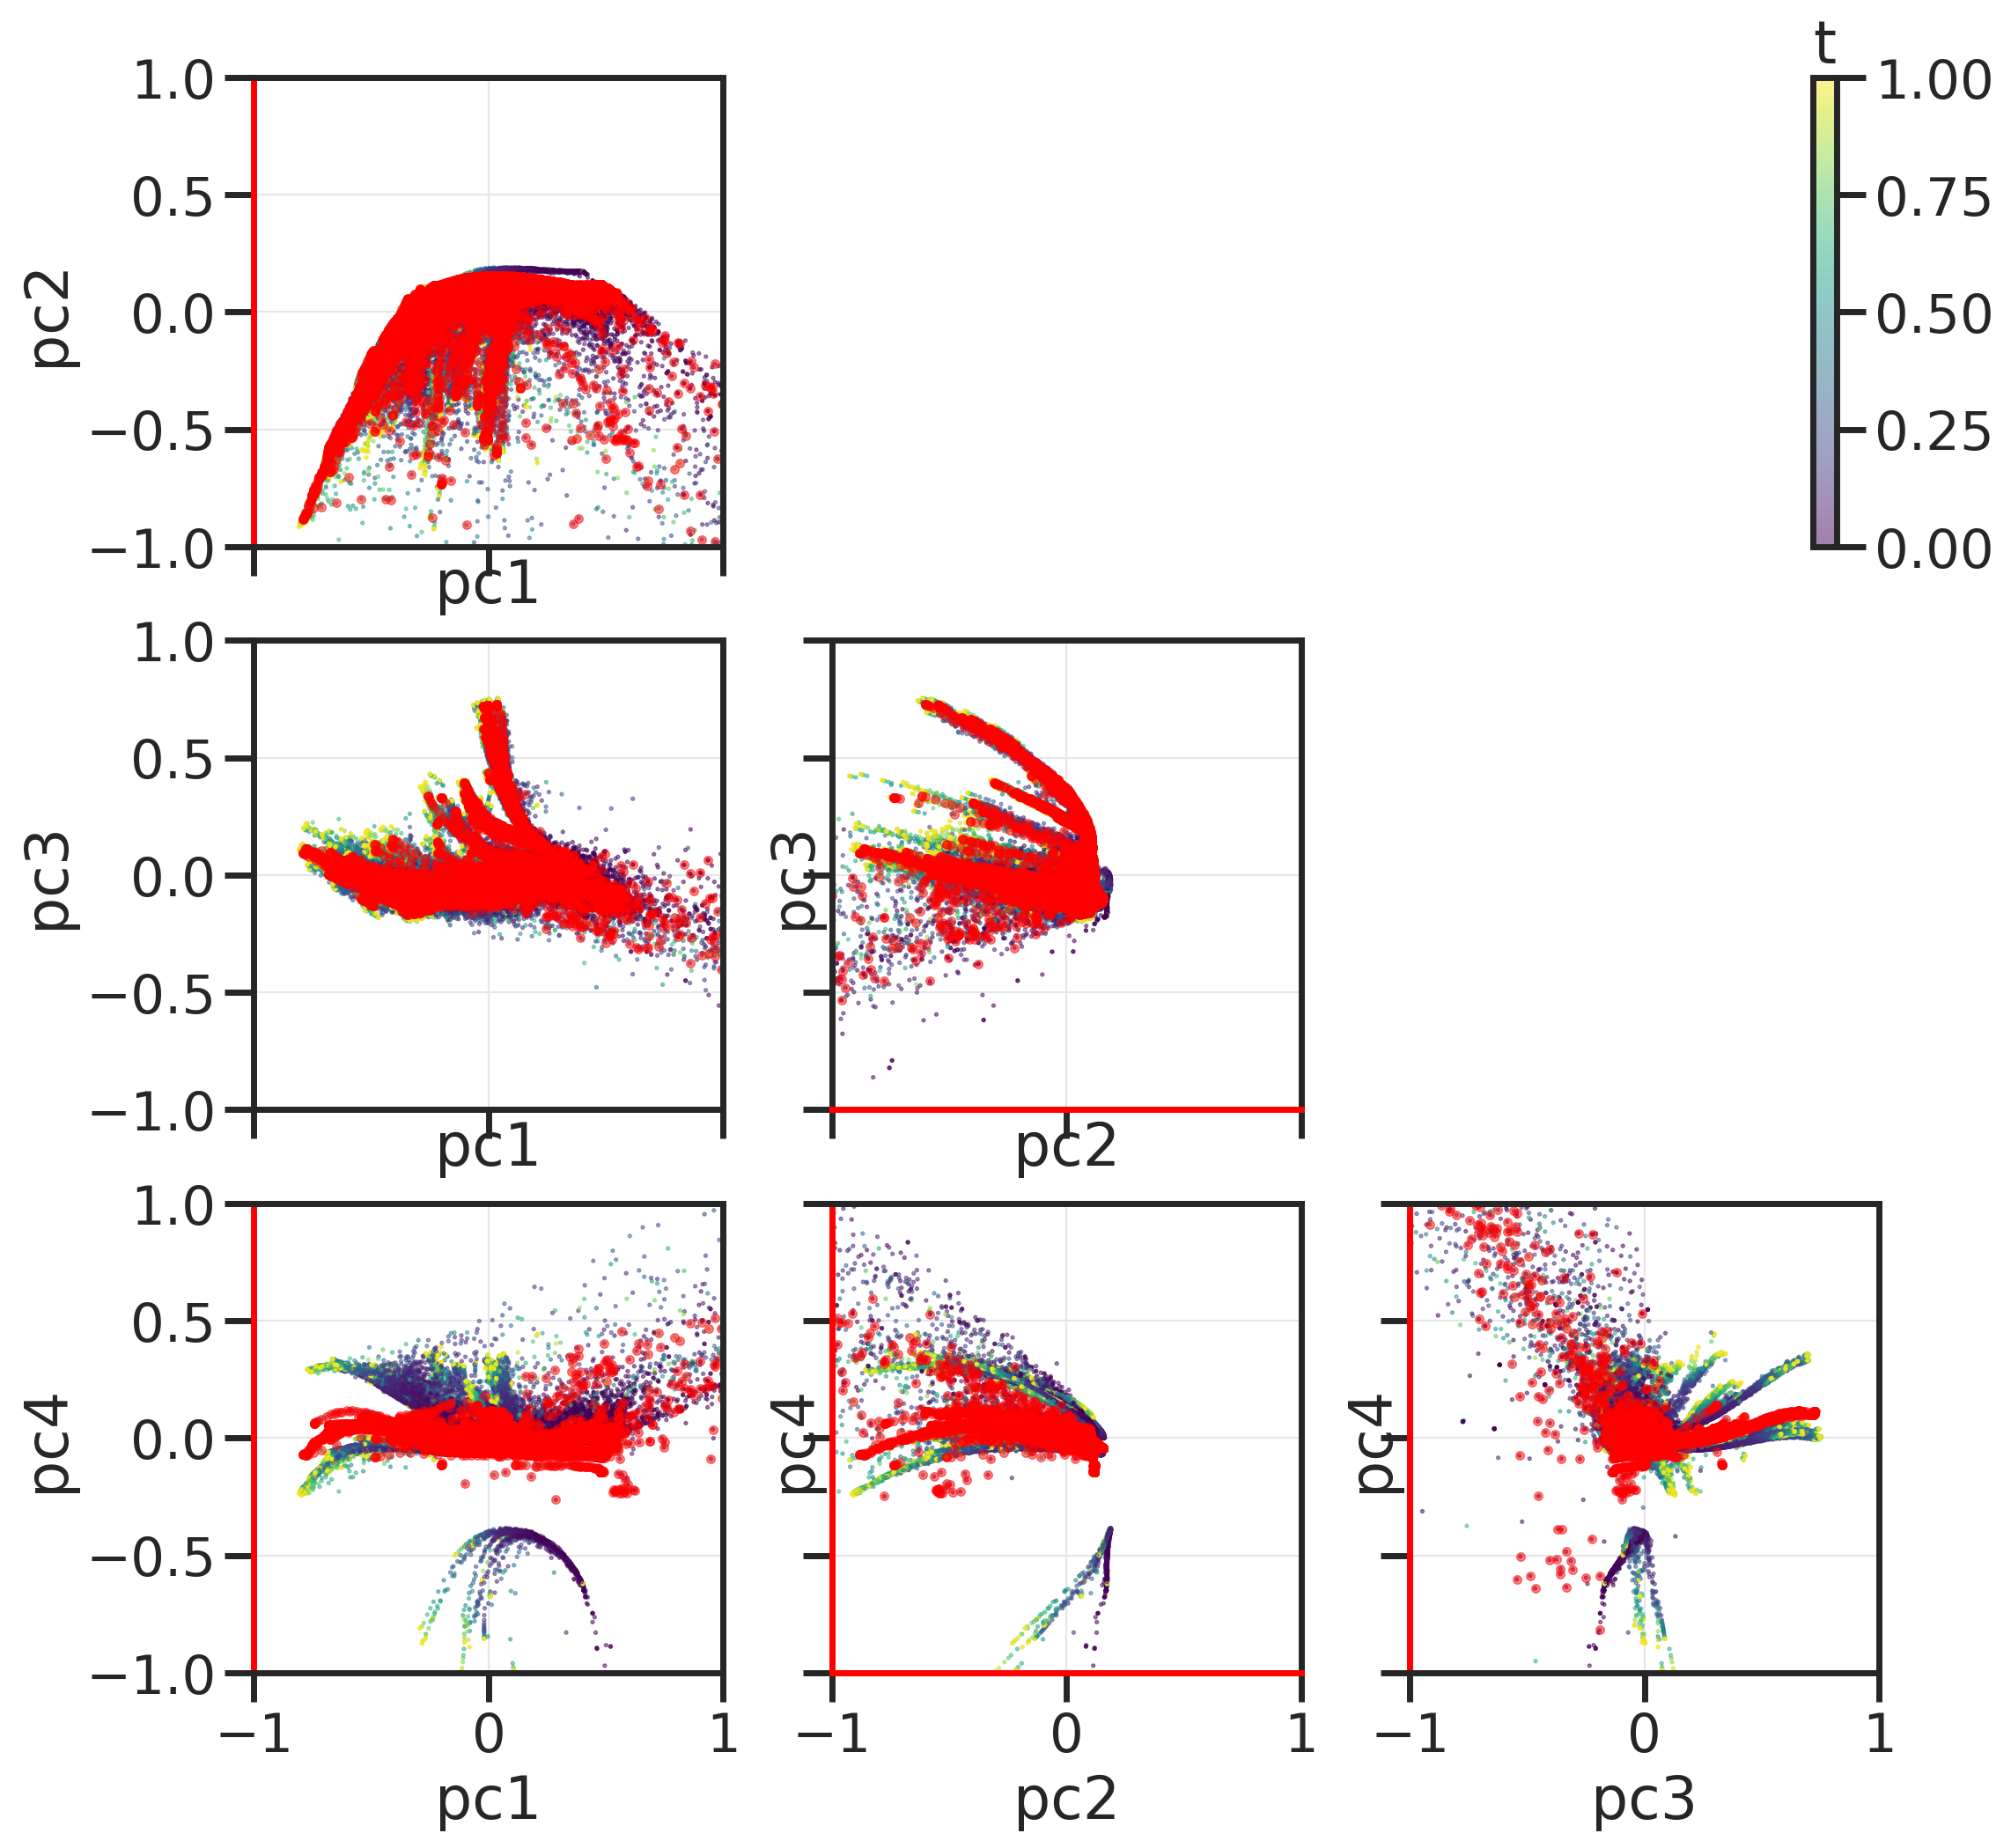

In [128]:
triplot(dd.reset_index(drop=True), r=r_, d=5, cmap='viridis', cdict=None, ckey='t',
            markers=["o", "x", "s", "*", "+", ".", ],
            evals=False, plot_avg=False
            )

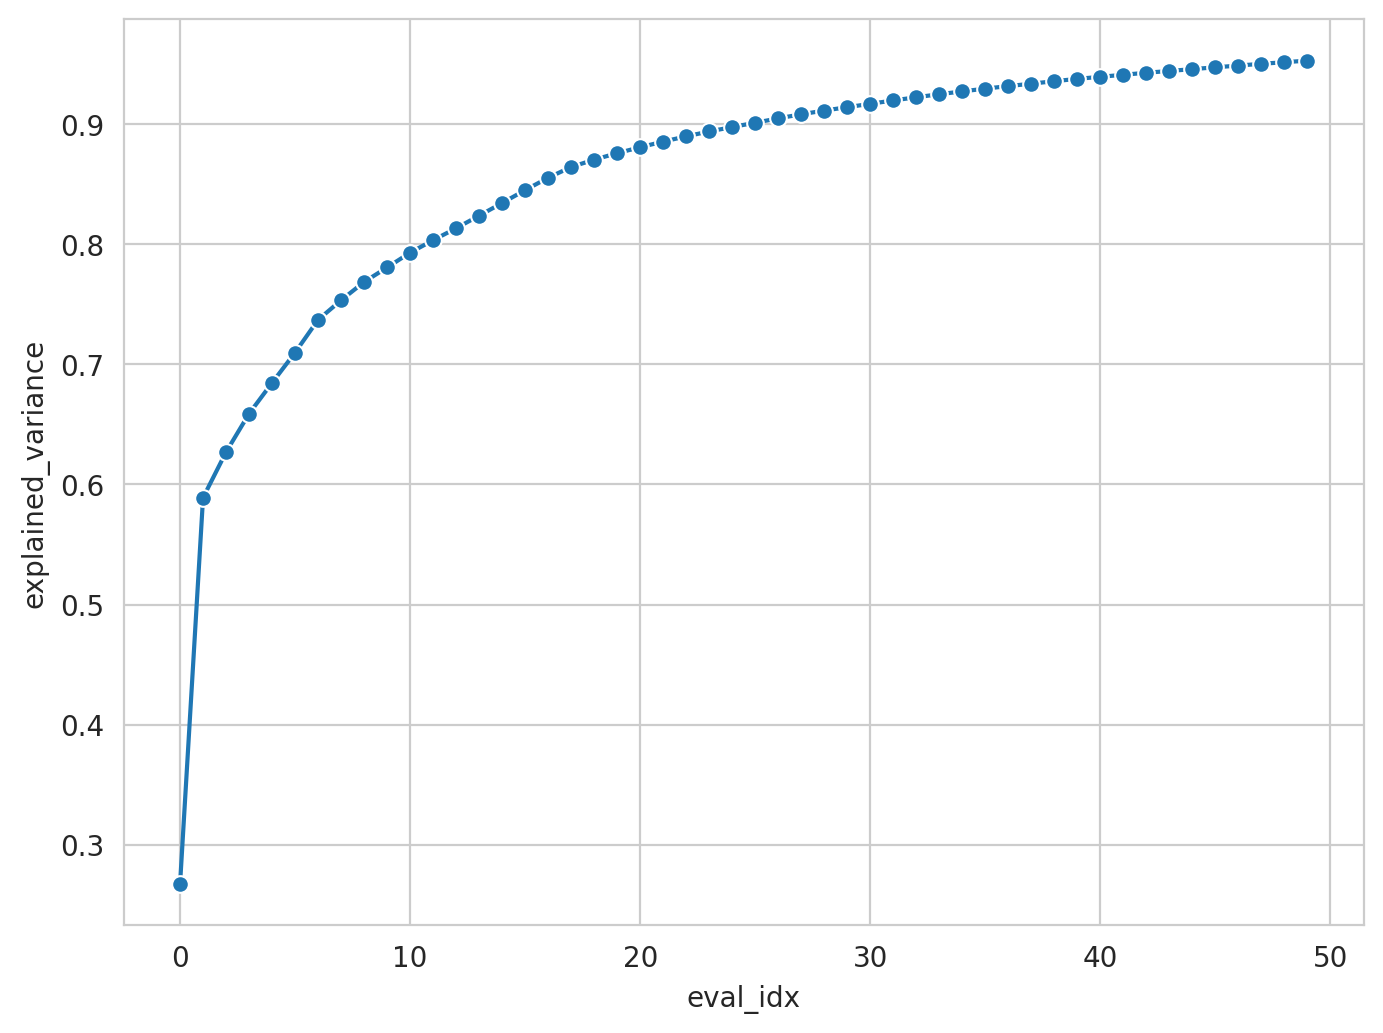

In [144]:
es = r['es'][-50::]
es =es[::-1]
df = pd.DataFrame(dict(eval_idx=np.arange(len(es)), explained_variance=1 - np.sqrt(1-np.cumsum(es ** 2)/r['fn']**2)))
plt.figure(figsize=(8,6))
g=sns.lineplot(data=df, x='eval_idx', y='explained_variance', marker="o")